<a href="https://colab.research.google.com/github/AbhigyanPandey08/Intelligent-Optimization-Framework-for-Strategic-Placement-of-Electric-Vehicle-Charging-Stations-/blob/main/EVCharging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# ------------------------------
# CONFIG
# ------------------------------

# Path to your merged national dataset
STATION_CSV = "ev_merged_india_full.csv"

# Number of demand nodes (clusters) for India-wide analysis.
# 150 is a good compromise between realism and speed.
N_CLUSTERS_NATIONAL = 150

# For state-level zoom analysis
N_CLUSTERS_STATE = 40    # you can adjust (e.g., 30–50)

# GA / optimization hyperparameters (you can tune later)
K_STATIONS = 150         # number of stations to select nationwide
BETA = 0.5               # grid vs detour tradeoff
R_SERVICE = 7.0          # service radius in km
THETA_COVERAGE = 0.85    # minimum coverage fraction
POP_SIZE = 80            # GA population
N_GENERATIONS = 150      # GA generations

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ------------------------------
# LOAD DATA
# ------------------------------

def load_station_data(path: str) -> pd.DataFrame:
    """
    Load the merged EV station + grid dataset.
    Required columns:
        - 'latitude'
        - 'longitude'
        - 'state_standard'
    Optional (for grid stress):
        - 'ev_load_MU'
        - 'pcs_count'
    """
    df = pd.read_csv(path)

    required = ['latitude', 'longitude', 'state_standard']
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' in {path}")

    if 'station_id' not in df.columns:
        df['station_id'] = np.arange(len(df))

    return df

stations_df = load_station_data(STATION_CSV)
print("Loaded stations:", stations_df.shape)
print(stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())
# Clean latitude and longitude columns: remove commas and cast to float
for col in ['latitude', 'longitude']:
    stations_df[col] = (
        stations_df[col]
        .astype(str)              # ensure string
        .str.replace(',', '', regex=False)  # remove any stray commas
    )

    stations_df[col] = pd.to_numeric(stations_df[col], errors='coerce')

# Check for any rows that became NaN after cleaning
bad_coords = stations_df[stations_df['latitude'].isna() | stations_df['longitude'].isna()]
print("Rows with invalid coordinates after cleaning:", len(bad_coords))

# Option 1: drop them (safe if very few)
stations_df = stations_df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)

print("Stations after coordinate cleaning:", stations_df.shape)
print(stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())


Loaded stations: (1533, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1           1        Haryana   28.4673    77.0818
2           2      Rajasthan   27.8751    76.2760
3           3  Uttar Pradesh   29.3105    77.7218
4           4  Uttar Pradesh   29.3105    77.7218
Rows with invalid coordinates after cleaning: 0
Stations after coordinate cleaning: (1533, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1           1        Haryana   28.4673    77.0818
2           2      Rajasthan   27.8751    76.2760
3           3  Uttar Pradesh   29.3105    77.7218
4           4  Uttar Pradesh   29.3105    77.7218


In [ ]:
print(sorted(stations_df['state_standard'].unique()))
print(stations_df['state_standard'].value_counts())


['Andaman', 'Andhra Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']
state_standard
Maharashtra         260
Tamil Nadu          181
Delhi               178
Karnataka           132
Kerala               93
Uttar Pradesh        87
Telangana            82
Gujarat              79
Rajasthan            67
Haryana              62
Andhra Pradesh       60
West Bengal          56
Odisha               40
Uttarakhand          25
Punjab               24
Jharkhand            22
Madhya Pradesh       20
Chhattisgarh         18
Assam                10
Goa                   8
Jammu & Kashmir       7
Bihar                 7
Himachal Pradesh      6
Puducherry            3
Chandigarh            2
Sikkim             

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# ============================================================
# 2A. CLEAN COORDINATES
# ============================================================

# Clean latitude and longitude: remove commas and cast to float
for col in ['latitude', 'longitude']:
    stations_df[col] = (
        stations_df[col]
        .astype(str)                             # ensure string
        .str.replace(',', '', regex=False)       # remove stray commas
    )
    stations_df[col] = pd.to_numeric(stations_df[col], errors='coerce')

# Check for invalid coordinates
bad_coords = stations_df[stations_df['latitude'].isna() | stations_df['longitude'].isna()]
print("Rows with invalid coordinates after cleaning:", len(bad_coords))

# Drop rows with NaN lat/lon (very few, safe to drop for optimization)
stations_df = stations_df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
print("Stations after NaN removal:", stations_df.shape)

# ============================================================
# 2B. FILTER TO VALID INDIA BOUNDING BOX
# ============================================================

# Approximate geographic bounds for India
lat_min, lat_max = 5.0, 38.0
lon_min, lon_max = 65.0, 100.0

valid_mask = (
    (stations_df['latitude'] >= lat_min) &
    (stations_df['latitude'] <= lat_max) &
    (stations_df['longitude'] >= lon_min) &
    (stations_df['longitude'] <= lon_max)
)

print("Stations before bounding-box filter:", stations_df.shape)
stations_df = stations_df[valid_mask].reset_index(drop=True)
print("Stations after bounding-box filter:", stations_df.shape)

print(stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())

# ============================================================
# 2C. HAVERSINE DISTANCE FUNCTION
# ============================================================

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute Haversine distance (in km) between points.
    lat1, lon1: scalars
    lat2, lon2: numpy arrays (broadcasting works).
    """
    R = 6371.0  # Earth radius in km

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# ============================================================
# 2D. DEMAND NODE CONSTRUCTION (NATIONAL LEVEL)
# ============================================================

def construct_demand_nodes(df: pd.DataFrame, n_clusters: int = 150):
    """
    Cluster station coordinates to create national-scale demand nodes.
    For now we use station locations as proxies for EV activity hotspots.
    Each cluster center is a demand node with a weight equal to the
    number of stations falling into that cluster.
    """
    coords = df[['latitude', 'longitude']].to_numpy()

    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10)
    labels = kmeans.fit_predict(coords)
    centers = kmeans.cluster_centers_

    demand_records = []
    for k in range(n_clusters):
        mask = (labels == k)
        weight = mask.sum()
        if weight <= 0:
            weight = 1.0
        demand_records.append({
            'demand_id': k,
            'latitude': centers[k, 0],
            'longitude': centers[k, 1],
            'weight': float(weight),
        })

    demand_df = pd.DataFrame(demand_records)
    w = demand_df['weight'].to_numpy(dtype=float)
    return demand_df, w

# Build national demand nodes
demand_national_df, w_national = construct_demand_nodes(
    stations_df,
    n_clusters=N_CLUSTERS_NATIONAL
)

print("National demand nodes:", demand_national_df.shape)
print(demand_national_df.head())

# ============================================================
# 2E. DISTANCE MATRIX: DEMAND × STATIONS
# ============================================================

def compute_distance_matrix(demand_df: pd.DataFrame, station_df: pd.DataFrame):
    """
    Compute Haversine distance matrix between demand nodes and stations.
    Shape: (m, n) where m = # demand nodes, n = # stations.
    """
    demand_lat = demand_df['latitude'].to_numpy()
    demand_lon = demand_df['longitude'].to_numpy()
    stat_lat = station_df['latitude'].to_numpy()
    stat_lon = station_df['longitude'].to_numpy()

    m = len(demand_df)
    n = len(station_df)
    dist = np.zeros((m, n), dtype=float)

    for i in range(m):
        dist[i, :] = haversine_distance(demand_lat[i], demand_lon[i], stat_lat, stat_lon)
    return dist

dist_national = compute_distance_matrix(demand_national_df, stations_df)
print("Distance matrix shape (demand × stations):", dist_national.shape)


Rows with invalid coordinates after cleaning: 0
Stations after NaN removal: (1533, 12)
Stations before bounding-box filter: (1533, 12)
Stations after bounding-box filter: (1533, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1           1        Haryana   28.4673    77.0818
2           2      Rajasthan   27.8751    76.2760
3           3  Uttar Pradesh   29.3105    77.7218
4           4  Uttar Pradesh   29.3105    77.7218
National demand nodes: (150, 4)
   demand_id   latitude  longitude  weight
0          0  20.312890  85.828625    19.0
1          1  18.920528  73.918850     3.0
2          2  28.620340  77.183357   138.0
3          3  10.381127  77.996814     2.0
4          4  17.447815  78.446790    70.0
Distance matrix shape (demand × stations): (150, 1533)


In [ ]:
# ============================================================
# 3A. GRID-STRESS INDEX G_j AND REGION MAPPING
# ============================================================

def compute_grid_stress_index_from_stations(station_df: pd.DataFrame):
    """
    Compute grid-stress index G_j per state (region) and map each station to a region index.

    Expected (ideal) columns in station_df:
        - 'state_standard'
        - 'ev_load_MU'   (state-level EV energy consumption, in MU)
        - 'pcs_count'    (number of public charging stations in that state)

    If 'ev_load_MU' and 'pcs_count' are NOT present, this falls back to
    a uniform grid-stress index (all zeros), effectively ignoring Ψ(x)
    and focusing only on detour minimization.
    """
    if {'ev_load_MU', 'pcs_count'}.issubset(station_df.columns):
        # Aggregate by state
        state_group = (
            station_df
            .groupby('state_standard', as_index=False)
            .agg({'ev_load_MU': 'mean', 'pcs_count': 'mean'})
        )

        # Raw stress proxy: EV load per PCS
        state_group['G_raw'] = state_group['ev_load_MU'] / (state_group['pcs_count'] + 1e-6)

        # Normalize G_raw to [0, 1]
        G_raw = state_group['G_raw'].to_numpy()
        G_min, G_max = G_raw.min(), G_raw.max()
        if G_max > G_min:
            G_norm = (G_raw - G_min) / (G_max - G_min)
        else:
            G_norm = np.zeros_like(G_raw)

        state_group['G'] = G_norm
        print("Computed grid-stress index from ev_load_MU and pcs_count.")
    else:
        # Fallback: no grid data → uniform stress = 0
        state_group = (
            station_df[['state_standard']]
            .drop_duplicates()
            .reset_index(drop=True)
        )
        state_group['G'] = 0.0
        print("Warning: 'ev_load_MU' and 'pcs_count' not found. Using uniform G_j = 0 (no grid penalty).")

    # Map each state to region index j
    state_to_idx = {s: j for j, s in enumerate(state_group['state_standard'])}
    region_idx = station_df['state_standard'].map(state_to_idx).to_numpy()
    G = state_group['G'].to_numpy()

    print("Number of grid regions:", len(G))
    return region_idx, G, state_group

region_idx_national, G_national, grid_states = compute_grid_stress_index_from_stations(stations_df)
print(grid_states.head())


Number of grid regions: 28
     state_standard    G
0           Haryana  0.0
1         Rajasthan  0.0
2     Uttar Pradesh  0.0
3  Himachal Pradesh  0.0
4       Maharashtra  0.0


In [ ]:
# ============================================================
# 3B. DETOUR AND COVERAGE
# ============================================================

def compute_detour_and_coverage(
    x: np.ndarray,
    dist_matrix: np.ndarray,
    weights: np.ndarray,
    R: float,
    theta: float
):
    """
    Compute weighted detour D(x) and coverage fraction for a given
    station selection vector x.

    x: binary array of length n_stations (1 = station selected)
    dist_matrix: shape (m, n), distances from demand nodes to stations
    weights: length-m vector of demand weights w_i
    R: service radius (km)
    theta: coverage target (e.g., 0.85)
    """
    m, n = dist_matrix.shape
    selected_idx = np.where(x == 1)[0]

    if len(selected_idx) == 0:
        # no stations selected → infinite penalty
        D_x = 1e9
        coverage = 0.0
        return D_x, coverage

    # Distance from each demand node to nearest selected station
    d_i = dist_matrix[:, selected_idx].min(axis=1)  # shape (m,)

    # Weighted detour
    D_x = float((weights * d_i).sum())

    # Coverage: indicator I(d_i <= R)
    covered = (d_i <= R).astype(float)
    coverage = float((weights * covered).sum() / weights.sum())

    return D_x, coverage

# ============================================================
# 3C. GRID-STRESS PENALTY Ψ(x)
# ============================================================

def compute_grid_penalty(
    x: np.ndarray,
    region_idx: np.ndarray,
    G: np.ndarray
):
    """
    Compute grid-stress penalty:
        Ψ(x) = sum_j G_j * (# of selected stations in region j)
    """
    Psi = 0.0
    n_regions = len(G)
    for j in range(n_regions):
        mask_j = (region_idx == j)
        Psi += G[j] * x[mask_j].sum()
    return float(Psi)

# ============================================================
# 3D. JOINT OBJECTIVE J(x) = D(x) + β Ψ(x)
# ============================================================

def objective_J(
    x: np.ndarray,
    dist_matrix: np.ndarray,
    weights: np.ndarray,
    region_idx: np.ndarray,
    G: np.ndarray,
    beta: float,
    R: float,
    theta: float,
    penalty_large: float = 1e6
):
    """
    Combined objective:
        J(x) = D(x) + beta * Ψ(x)
    with an additional penalty if coverage < theta.
    """
    D_x, coverage = compute_detour_and_coverage(x, dist_matrix, weights, R, theta)
    Psi_x = compute_grid_penalty(x, region_idx, G)

    J_x = D_x + beta * Psi_x

    # Hard coverage requirement via penalty
    if coverage < theta:
        J_x += penalty_large * (theta - coverage)

    return J_x


In [ ]:
# ============================================================
# 3E. QUICK TEST OF OBJECTIVE ON A RANDOM SELECTION
# ============================================================

n_stations = stations_df.shape[0]

# Build a random feasible vector with exactly K_STATIONS selected
x_rand = np.zeros(n_stations, dtype=int)
chosen = np.random.choice(n_stations, size=K_STATIONS, replace=False)
x_rand[chosen] = 1

D_test, cov_test = compute_detour_and_coverage(
    x_rand, dist_national, w_national, R_SERVICE, THETA_COVERAGE
)
Psi_test = compute_grid_penalty(x_rand, region_idx_national, G_national)
J_test = objective_J(
    x_rand, dist_national, w_national,
    region_idx_national, G_national,
    BETA, R_SERVICE, THETA_COVERAGE
)

print(f"Random solution -> D(x) = {D_test:.2f}, coverage = {cov_test:.3f}, Ψ(x) = {Psi_test:.2f}, J(x) = {J_test:.2f}")


Random solution -> D(x) = 39552.62, coverage = 0.594, Ψ(x) = 0.00, J(x) = 295945.32


In [ ]:
# ============================================================
# 4A. GENETIC ALGORITHM COMPONENTS
# ============================================================

def initialize_population(pop_size: int, n_stations: int, K: int) -> np.ndarray:
    """
    Initialize GA population with pop_size individuals,
    each selecting exactly K stations.
    """
    pop = np.zeros((pop_size, n_stations), dtype=int)
    for i in range(pop_size):
        chosen = np.random.choice(n_stations, size=K, replace=False)
        pop[i, chosen] = 1
    return pop


def repair_individual(x: np.ndarray, K: int) -> np.ndarray:
    """
    Ensure sum(x) = K by turning bits on/off randomly.
    """
    x = x.copy()
    current_K = int(x.sum())
    if current_K > K:
        ones_idx = np.where(x == 1)[0]
        to_flip = np.random.choice(ones_idx, size=current_K - K, replace=False)
        x[to_flip] = 0
    elif current_K < K:
        zeros_idx = np.where(x == 0)[0]
        to_flip = np.random.choice(zeros_idx, size=K - current_K, replace=False)
        x[to_flip] = 1
    return x


def tournament_selection(pop: np.ndarray, fitness: np.ndarray, k: int = 3) -> np.ndarray:
    """
    Tournament selection: pick k individuals, return the best (lowest J).
    """
    idx = np.random.choice(len(pop), size=k, replace=False)
    best_idx = idx[np.argmin(fitness[idx])]
    return pop[best_idx].copy()


def uniform_crossover(p1: np.ndarray, p2: np.ndarray, cx_prob: float = 0.5):
    """
    Uniform crossover between two parents.
    """
    mask = np.random.rand(len(p1)) < cx_prob
    c1 = p1.copy()
    c2 = p2.copy()
    c1[mask] = p2[mask]
    c2[mask] = p1[mask]
    return c1, c2


def mutation_bitflip(x: np.ndarray, mut_prob: float = 0.01) -> np.ndarray:
    """
    Bit-flip mutation with probability mut_prob per bit.
    """
    x = x.copy()
    flip_mask = np.random.rand(len(x)) < mut_prob
    x[flip_mask] = 1 - x[flip_mask]
    return x


def run_ga(
    dist_matrix: np.ndarray,
    weights: np.ndarray,
    region_idx: np.ndarray,
    G: np.ndarray,
    K: int,
    beta: float,
    R: float,
    theta: float,
    pop_size: int = 80,
    n_generations: int = 150,
    cx_prob: float = 0.5,
    mut_prob: float = 0.01,
    elitism: int = 2,
):
    """
    Run GA to minimize J(x) = D(x) + beta * Ψ(x) under:
        - sum(x) = K
        - coverage >= theta (enforced by penalty in objective_J).
    """
    n_stations = dist_matrix.shape[1]

    # Initialize population
    pop = initialize_population(pop_size, n_stations, K)

    # Evaluate initial population
    fitness = np.array([
        objective_J(ind, dist_matrix, weights, region_idx, G, beta, R, theta)
        for ind in pop
    ])

    best_idx = np.argmin(fitness)
    best_x = pop[best_idx].copy()
    best_f = fitness[best_idx]
    history = [best_f]

    for gen in range(n_generations):
        new_pop = []

        # Elitism: keep top 'elitism' individuals
        elite_indices = fitness.argsort()[:elitism]
        for ei in elite_indices:
            new_pop.append(pop[ei].copy())

        # Fill rest of population
        while len(new_pop) < pop_size:
            parent1 = tournament_selection(pop, fitness)
            parent2 = tournament_selection(pop, fitness)

            child1, child2 = uniform_crossover(parent1, parent2, cx_prob)
            child1 = mutation_bitflip(child1, mut_prob)
            child2 = mutation_bitflip(child2, mut_prob)

            child1 = repair_individual(child1, K)
            child2 = repair_individual(child2, K)

            new_pop.append(child1)
            if len(new_pop) < pop_size:
                new_pop.append(child2)

        pop = np.array(new_pop)

        # Recompute fitness
        fitness = np.array([
            objective_J(ind, dist_matrix, weights, region_idx, G, beta, R, theta)
            for ind in pop
        ])

        # Track best so far
        best_idx = np.argmin(fitness)
        if fitness[best_idx] < best_f:
            best_f = fitness[best_idx]
            best_x = pop[best_idx].copy()
        history.append(best_f)

        if (gen + 1) % 20 == 0:
            print(f"Generation {gen+1}/{n_generations} -> best J(x) = {best_f:.2f}")

    return {
        "best_x": best_x,
        "best_f": best_f,
        "history": history,
    }


# ============================================================
# 4B. RUN GA FOR NATIONAL-LEVEL OPTIMIZATION
# ============================================================

result_nat = run_ga(
    dist_matrix=dist_national,
    weights=w_national,
    region_idx=region_idx_national,
    G=G_national,
    K=K_STATIONS,
    beta=BETA,
    R=R_SERVICE,
    theta=THETA_COVERAGE,
    pop_size=POP_SIZE,
    n_generations=N_GENERATIONS,
)

best_x_nat = result_nat["best_x"]
best_f_nat = result_nat["best_f"]
print("\n=== GA National Optimization Result ===")
print(f"Best J(x) = {best_f_nat:.2f}")
print(f"Stations selected: {int(best_x_nat.sum())}")

# Evaluate final solution
D_best, cov_best = compute_detour_and_coverage(
    best_x_nat, dist_national, w_national, R_SERVICE, THETA_COVERAGE
)
Psi_best = compute_grid_penalty(best_x_nat, region_idx_national, G_national)

print(f"Final detour D(x) = {D_best:.2f}")
print(f"Final coverage    = {cov_best:.3f}")
print(f"Final grid Ψ(x)   = {Psi_best:.2f}")


Generation 20/150 -> best J(x) = 117606.31
Generation 40/150 -> best J(x) = 97919.91
Generation 60/150 -> best J(x) = 96692.50
Generation 80/150 -> best J(x) = 88134.62
Generation 100/150 -> best J(x) = 88134.62
Generation 120/150 -> best J(x) = 81241.48
Generation 140/150 -> best J(x) = 75015.67

=== GA National Optimization Result ===
Best J(x) = 75015.67
Stations selected: 150
Final detour D(x) = 28016.32
Final coverage    = 0.803
Final grid Ψ(x)   = 0.00


In [ ]:
# ============================================================
# 5A. EXTRACT OPTIMIZED STATION SET
# ============================================================

# best_x_nat is a 0/1 vector aligned with stations_df rows
selected_mask = (best_x_nat == 1)
selected_stations_df = stations_df[selected_mask].copy()
selected_stations_df.reset_index(drop=True, inplace=True)

print("Selected stations dataframe shape:", selected_stations_df.shape)
print(selected_stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())

# Optionally save to CSV for mapping / GIS visualization
selected_stations_df.to_csv("optimized_ev_stations_india_K150.csv", index=False)
print("Saved optimized station set to 'optimized_ev_stations_india_K150.csv'.")

# ============================================================
# 5B. STATE-LEVEL DISTRIBUTION OF SELECTED STATIONS
# ============================================================

state_counts_opt = selected_stations_df['state_standard'].value_counts().sort_index()
state_counts_all = stations_df['state_standard'].value_counts().sort_index()

state_dist_df = pd.DataFrame({
    'state': state_counts_all.index,
    'all_stations': state_counts_all.values,
    'selected_stations': state_counts_opt.reindex(state_counts_all.index, fill_value=0).values
})
state_dist_df['selection_ratio'] = state_dist_df['selected_stations'] / state_dist_df['all_stations']

print("\nState-wise station deployment (all vs optimized K=150):")
print(state_dist_df.head(15))  # first 15 states

# ============================================================
# 5C. BASELINE VS OPTIMIZED COMPARISON (RANDOM NETWORK)
# ============================================================

# Build a random feasible network for baseline
n_stations = stations_df.shape[0]
x_random = np.zeros(n_stations, dtype=int)
rand_idx = np.random.choice(n_stations, size=K_STATIONS, replace=False)
x_random[rand_idx] = 1

D_rand, cov_rand = compute_detour_and_coverage(
    x_random, dist_national, w_national, R_SERVICE, THETA_COVERAGE
)
Psi_rand = compute_grid_penalty(x_random, region_idx_national, G_national)
J_rand = objective_J(
    x_random, dist_national, w_national,
    region_idx_national, G_national,
    BETA, R_SERVICE, THETA_COVERAGE
)

print("\n=== Baseline vs Optimized Comparison ===")
print(f"Random  K={K_STATIONS}: D(x) = {D_rand:.2f}, coverage = {cov_rand:.3f}, J(x) = {J_rand:.2f}")
print(f"Optimized K={K_STATIONS}: D(x) = {D_best:.2f}, coverage = {cov_best:.3f}, J(x) = {best_f_nat:.2f}")

detour_improvement_pct = 100.0 * (D_rand - D_best) / D_rand
print(f"Detour reduction vs random baseline: {detour_improvement_pct:.1f}%")


Selected stations dataframe shape: (150, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1          14     Tamil Nadu   11.3217    76.9163
2          57    Maharashtra   18.0855    73.4309
3          59      Karnataka   12.8576    74.8383
4          65          Delhi   32.9892    74.9289
Saved optimized station set to 'optimized_ev_stations_india_K150.csv'.

State-wise station deployment (all vs optimized K=150):
               state  all_stations  selected_stations  selection_ratio
0            Andaman             1                  0         0.000000
1     Andhra Pradesh            60                  5         0.083333
2              Assam            10                  1         0.100000
3              Bihar             7                  0         0.000000
4         Chandigarh             2                  0         0.000000
5       Chhattisgarh            18                  3         0.166667
6              Delhi          

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# ------------------------------
# CONFIG
# ------------------------------

# Path to your merged national dataset
STATION_CSV = "ev_merged_india_full.csv"

# Number of demand nodes (clusters) for India-wide analysis.
# 150 is a good compromise between realism and speed.
N_CLUSTERS_NATIONAL = 150

# For state-level zoom analysis
N_CLUSTERS_STATE = 40    # you can adjust (e.g., 30–50)

# GA / optimization hyperparameters (you can tune later)
K_STATIONS = 150          # still 150, for fair comparison
BETA = 0.5                # same beta for now
R_SERVICE = 7.0           # same service radius
THETA_COVERAGE = 0.85     # same coverage target
# Stronger GA search:
POP_SIZE = 120            # was 80
N_GENERATIONS = 300       # was 150
# Multi-start GA runs:
N_GA_RUNS = 5             # number of independent GA runs (different seeds)

# ============================================================
# 4A-extra. MULTI-START GA WRAPPER
# ============================================================

def run_ga_multi_start(
    dist_matrix,
    weights,
    region_idx,
    G,
    K,
    beta,
    R,
    theta,
    pop_size=120,
    n_generations=300,
    n_runs=5,
):
    """
    Run GA multiple times with different random seeds
    and keep the best solution across all runs.
    """
    best_overall_f = np.inf
    best_overall_x = None
    best_history_all = []

    for run in range(n_runs):
        print(f"\n=== GA Run {run+1}/{n_runs} ===")
        # change seed each run for diversity
        np.random.seed(42 + run)

        result = run_ga(
            dist_matrix=dist_matrix,
            weights=weights,
            region_idx=region_idx,
            G=G,
            K=K,
            beta=beta,
            R=R,
            theta=theta,
            pop_size=pop_size,
            n_generations=n_generations,
        )

        best_x = result["best_x"]
        best_f = result["best_f"]
        history = result["history"]
        best_history_all.append(history)

        print(f"Run {run+1} best J(x) = {best_f:.2f}")

        if best_f < best_overall_f:
            best_overall_f = best_f
            best_overall_x = best_x.copy()

    return {
        "best_x": best_overall_x,
        "best_f": best_overall_f,
        "histories": best_history_all,
    }

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ------------------------------
# LOAD DATA
# ------------------------------

def load_station_data(path: str) -> pd.DataFrame:
    """
    Load the merged EV station + grid dataset.
    Required columns:
        - 'latitude'
        - 'longitude'
        - 'state_standard'
    Optional (for grid stress):
        - 'ev_load_MU'
        - 'pcs_count'
    """
    df = pd.read_csv(path)

    required = ['latitude', 'longitude', 'state_standard']
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' in {path}")

    if 'station_id' not in df.columns:
        df['station_id'] = np.arange(len(df))

    return df

stations_df = load_station_data(STATION_CSV)
print("Loaded stations:", stations_df.shape)
print(stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())
# Clean latitude and longitude columns: remove commas and cast to float
for col in ['latitude', 'longitude']:
    stations_df[col] = (
        stations_df[col]
        .astype(str)              # ensure string
        .str.replace(',', '', regex=False)  # remove any stray commas
    )

    stations_df[col] = pd.to_numeric(stations_df[col], errors='coerce')

# Check for any rows that became NaN after cleaning
bad_coords = stations_df[stations_df['latitude'].isna() | stations_df['longitude'].isna()]
print("Rows with invalid coordinates after cleaning:", len(bad_coords))

# Option 1: drop them (safe if very few)
stations_df = stations_df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)

print("Stations after coordinate cleaning:", stations_df.shape)
print(stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())


Loaded stations: (1533, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1           1        Haryana   28.4673    77.0818
2           2      Rajasthan   27.8751    76.2760
3           3  Uttar Pradesh   29.3105    77.7218
4           4  Uttar Pradesh   29.3105    77.7218
Rows with invalid coordinates after cleaning: 0
Stations after coordinate cleaning: (1533, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1           1        Haryana   28.4673    77.0818
2           2      Rajasthan   27.8751    76.2760
3           3  Uttar Pradesh   29.3105    77.7218
4           4  Uttar Pradesh   29.3105    77.7218


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# ============================================================
# 2A. CLEAN COORDINATES
# ============================================================

# Clean latitude and longitude: remove commas and cast to float
for col in ['latitude', 'longitude']:
    stations_df[col] = (
        stations_df[col]
        .astype(str)                             # ensure string
        .str.replace(',', '', regex=False)       # remove stray commas
    )
    stations_df[col] = pd.to_numeric(stations_df[col], errors='coerce')

# Check for invalid coordinates
bad_coords = stations_df[stations_df['latitude'].isna() | stations_df['longitude'].isna()]
print("Rows with invalid coordinates after cleaning:", len(bad_coords))

# Drop rows with NaN lat/lon (very few, safe to drop for optimization)
stations_df = stations_df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
print("Stations after NaN removal:", stations_df.shape)

# ============================================================
# 2B. FILTER TO VALID INDIA BOUNDING BOX
# ============================================================

# Approximate geographic bounds for India
lat_min, lat_max = 5.0, 38.0
lon_min, lon_max = 65.0, 100.0

valid_mask = (
    (stations_df['latitude'] >= lat_min) &
    (stations_df['latitude'] <= lat_max) &
    (stations_df['longitude'] >= lon_min) &
    (stations_df['longitude'] <= lon_max)
)

print("Stations before bounding-box filter:", stations_df.shape)
stations_df = stations_df[valid_mask].reset_index(drop=True)
print("Stations after bounding-box filter:", stations_df.shape)

print(stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())

# ============================================================
# 2C. HAVERSINE DISTANCE FUNCTION
# ============================================================

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute Haversine distance (in km) between points.
    lat1, lon1: scalars
    lat2, lon2: numpy arrays (broadcasting works).
    """
    R = 6371.0  # Earth radius in km

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# ============================================================
# 2D. DEMAND NODE CONSTRUCTION (NATIONAL LEVEL)
# ============================================================

def construct_demand_nodes(df: pd.DataFrame, n_clusters: int = 150):
    """
    Cluster station coordinates to create national-scale demand nodes.
    For now we use station locations as proxies for EV activity hotspots.
    Each cluster center is a demand node with a weight equal to the
    number of stations falling into that cluster.
    """
    coords = df[['latitude', 'longitude']].to_numpy()

    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10)
    labels = kmeans.fit_predict(coords)
    centers = kmeans.cluster_centers_

    demand_records = []
    for k in range(n_clusters):
        mask = (labels == k)
        weight = mask.sum()
        if weight <= 0:
            weight = 1.0
        demand_records.append({
            'demand_id': k,
            'latitude': centers[k, 0],
            'longitude': centers[k, 1],
            'weight': float(weight),
        })

    demand_df = pd.DataFrame(demand_records)
    w = demand_df['weight'].to_numpy(dtype=float)
    return demand_df, w

# Build national demand nodes
demand_national_df, w_national = construct_demand_nodes(
    stations_df,
    n_clusters=N_CLUSTERS_NATIONAL
)

print("National demand nodes:", demand_national_df.shape)
print(demand_national_df.head())

# ============================================================
# 2E. DISTANCE MATRIX: DEMAND × STATIONS
# ============================================================

def compute_distance_matrix(demand_df: pd.DataFrame, station_df: pd.DataFrame):
    """
    Compute Haversine distance matrix between demand nodes and stations.
    Shape: (m, n) where m = # demand nodes, n = # stations.
    """
    demand_lat = demand_df['latitude'].to_numpy()
    demand_lon = demand_df['longitude'].to_numpy()
    stat_lat = station_df['latitude'].to_numpy()
    stat_lon = station_df['longitude'].to_numpy()

    m = len(demand_df)
    n = len(station_df)
    dist = np.zeros((m, n), dtype=float)

    for i in range(m):
        dist[i, :] = haversine_distance(demand_lat[i], demand_lon[i], stat_lat, stat_lon)
    return dist

dist_national = compute_distance_matrix(demand_national_df, stations_df)
print("Distance matrix shape (demand × stations):", dist_national.shape)


Rows with invalid coordinates after cleaning: 0
Stations after NaN removal: (1533, 12)
Stations before bounding-box filter: (1533, 12)
Stations after bounding-box filter: (1533, 12)
   station_id state_standard  latitude  longitude
0           0        Haryana   29.6019    76.9803
1           1        Haryana   28.4673    77.0818
2           2      Rajasthan   27.8751    76.2760
3           3  Uttar Pradesh   29.3105    77.7218
4           4  Uttar Pradesh   29.3105    77.7218
National demand nodes: (150, 4)
   demand_id   latitude  longitude  weight
0          0  20.312890  85.828625    19.0
1          1  18.920528  73.918850     3.0
2          2  28.620340  77.183357   138.0
3          3  10.381127  77.996814     2.0
4          4  17.447815  78.446790    70.0
Distance matrix shape (demand × stations): (150, 1533)


In [ ]:
# ============================================================
# 3A. GRID-STRESS INDEX G_j AND REGION MAPPING
# ============================================================

def compute_grid_stress_index_from_stations(station_df: pd.DataFrame):
    """
    Compute grid-stress index G_j per state (region) and map each station to a region index.

    Expected (ideal) columns in station_df:
        - 'state_standard'
        - 'ev_load_MU'   (state-level EV energy consumption, in MU)
        - 'pcs_count'    (number of public charging stations in that state)

    If 'ev_load_MU' and 'pcs_count' are NOT present, this falls back to
    a uniform grid-stress index (all zeros), effectively ignoring Ψ(x)
    and focusing only on detour minimization.
    """
    if {'ev_load_MU', 'pcs_count'}.issubset(station_df.columns):
        # Aggregate by state
        state_group = (
            station_df
            .groupby('state_standard', as_index=False)
            .agg({'ev_load_MU': 'mean', 'pcs_count': 'mean'})
        )

        # Raw stress proxy: EV load per PCS
        state_group['G_raw'] = state_group['ev_load_MU'] / (state_group['pcs_count'] + 1e-6)

        # Normalize G_raw to [0, 1]
        G_raw = state_group['G_raw'].to_numpy()
        G_min, G_max = G_raw.min(), G_raw.max()
        if G_max > G_min:
            G_norm = (G_raw - G_min) / (G_max - G_min)
        else:
            G_norm = np.zeros_like(G_raw)

        state_group['G'] = G_norm
        print("Computed grid-stress index from ev_load_MU and pcs_count.")
    else:
        # Fallback: no grid data → uniform stress = 0
        state_group = (
            station_df[['state_standard']]
            .drop_duplicates()
            .reset_index(drop=True)
        )
        state_group['G'] = 0.0
        print("Warning: 'ev_load_MU' and 'pcs_count' not found. Using uniform G_j = 0 (no grid penalty).")

    # Map each state to region index j
    state_to_idx = {s: j for j, s in enumerate(state_group['state_standard'])}
    region_idx = station_df['state_standard'].map(state_to_idx).to_numpy()
    G = state_group['G'].to_numpy()

    print("Number of grid regions:", len(G))
    return region_idx, G, state_group

region_idx_national, G_national, grid_states = compute_grid_stress_index_from_stations(stations_df)
print(grid_states.head())


Number of grid regions: 28
     state_standard    G
0           Haryana  0.0
1         Rajasthan  0.0
2     Uttar Pradesh  0.0
3  Himachal Pradesh  0.0
4       Maharashtra  0.0


In [ ]:
# ============================================================
# 3B. DETOUR AND COVERAGE
# ============================================================

def compute_detour_and_coverage(
    x: np.ndarray,
    dist_matrix: np.ndarray,
    weights: np.ndarray,
    R: float,
    theta: float
):
    """
    Compute weighted detour D(x) and coverage fraction for a given
    station selection vector x.

    x: binary array of length n_stations (1 = station selected)
    dist_matrix: shape (m, n), distances from demand nodes to stations
    weights: length-m vector of demand weights w_i
    R: service radius (km)
    theta: coverage target (e.g., 0.85)
    """
    m, n = dist_matrix.shape
    selected_idx = np.where(x == 1)[0]

    if len(selected_idx) == 0:
        # no stations selected → infinite penalty
        D_x = 1e9
        coverage = 0.0
        return D_x, coverage

    # Distance from each demand node to nearest selected station
    d_i = dist_matrix[:, selected_idx].min(axis=1)  # shape (m,)

    # Weighted detour
    D_x = float((weights * d_i).sum())

    # Coverage: indicator I(d_i <= R)
    covered = (d_i <= R).astype(float)
    coverage = float((weights * covered).sum() / weights.sum())

    return D_x, coverage

# ============================================================
# 3C. GRID-STRESS PENALTY Ψ(x)
# ============================================================

def compute_grid_penalty(
    x: np.ndarray,
    region_idx: np.ndarray,
    G: np.ndarray
):
    """
    Compute grid-stress penalty:
        Ψ(x) = sum_j G_j * (# of selected stations in region j)
    """
    Psi = 0.0
    n_regions = len(G)
    for j in range(n_regions):
        mask_j = (region_idx == j)
        Psi += G[j] * x[mask_j].sum()
    return float(Psi)

# ============================================================
# 3D. JOINT OBJECTIVE J(x) = D(x) + β Ψ(x)
# ============================================================

def objective_J(
    x: np.ndarray,
    dist_matrix: np.ndarray,
    weights: np.ndarray,
    region_idx: np.ndarray,
    G: np.ndarray,
    beta: float,
    R: float,
    theta: float,
    penalty_large: float = 1e6
):
    """
    Combined objective:
        J(x) = D(x) + beta * Ψ(x)
    with an additional penalty if coverage < theta.
    """
    D_x, coverage = compute_detour_and_coverage(x, dist_matrix, weights, R, theta)
    Psi_x = compute_grid_penalty(x, region_idx, G)

    J_x = D_x + beta * Psi_x

    # Hard coverage requirement via penalty
    if coverage < theta:
        J_x += penalty_large * (theta - coverage)

    return J_x


In [ ]:
# ============================================================
# 3E. QUICK TEST OF OBJECTIVE ON A RANDOM SELECTION
# ============================================================

n_stations = stations_df.shape[0]

# Build a random feasible vector with exactly K_STATIONS selected
x_rand = np.zeros(n_stations, dtype=int)
chosen = np.random.choice(n_stations, size=K_STATIONS, replace=False)
x_rand[chosen] = 1

D_test, cov_test = compute_detour_and_coverage(
    x_rand, dist_national, w_national, R_SERVICE, THETA_COVERAGE
)
Psi_test = compute_grid_penalty(x_rand, region_idx_national, G_national)
J_test = objective_J(
    x_rand, dist_national, w_national,
    region_idx_national, G_national,
    BETA, R_SERVICE, THETA_COVERAGE
)

print(f"Random solution -> D(x) = {D_test:.2f}, coverage = {cov_test:.3f}, Ψ(x) = {Psi_test:.2f}, J(x) = {J_test:.2f}")


Random solution -> D(x) = 39552.62, coverage = 0.594, Ψ(x) = 0.00, J(x) = 295945.32


In [ ]:
# ============================================================
# 4A. GENETIC ALGORITHM COMPONENTS (with alpha + beta)
# ============================================================

ALPHA = 0.7   # detour weight
BETA = 0.3    # grid-stress weight

def initialize_population(pop_size: int, n_stations: int, K: int) -> np.ndarray:
    pop = np.zeros((pop_size, n_stations), dtype=int)
    for i in range(pop_size):
        pop[i, np.random.choice(n_stations, size=K, replace=False)] = 1
    return pop


def repair_individual(x: np.ndarray, K: int) -> np.ndarray:
    x = x.copy()
    current = int(x.sum())
    if current > K:
        idx = np.where(x == 1)[0]
        x[np.random.choice(idx, current-K, replace=False)] = 0
    elif current < K:
        idx = np.where(x == 0)[0]
        x[np.random.choice(idx, K-current, replace=False)] = 1
    return x


def tournament_selection(pop, fitness, k=3):
    idx = np.random.choice(len(pop), size=k, replace=False)
    return pop[idx[np.argmin(fitness[idx])]].copy()


def uniform_crossover(p1, p2, cx_prob=0.5):
    mask = np.random.rand(len(p1)) < cx_prob
    c1, c2 = p1.copy(), p2.copy()
    c1[mask], c2[mask] = p2[mask], p1[mask]
    return c1, c2


def mutation_bitflip(x, mut_prob=0.01):
    x = x.copy()
    mask = np.random.rand(len(x)) < mut_prob
    x[mask] = 1 - x[mask]
    return x


def run_ga(dist_matrix, weights, region_idx, G, K, alpha, beta, R, theta,
           pop_size=80, n_generations=150, cx_prob=0.5, mut_prob=0.01, elitism=2):
    """
    Minimize: J(x) = alpha * D(x) + beta * Ψ(x)
    s.t. coverage >= theta and sum(x) = K
    """
    n_stations = dist_matrix.shape[1]
    pop = initialize_population(pop_size, n_stations, K)

    fitness = np.array([
        objective_J(ind, dist_matrix, weights, region_idx, G,
                    alpha, beta, R, theta)
        for ind in pop
    ])

    best_idx = np.argmin(fitness)
    best_x = pop[best_idx].copy()
    best_f = fitness[best_idx]

    for gen in range(n_generations):
        new_pop = []

        elites = fitness.argsort()[:elitism]
        new_pop.extend(pop[e].copy() for e in elites)

        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fitness)
            p2 = tournament_selection(pop, fitness)

            c1, c2 = uniform_crossover(p1, p2, cx_prob)
            c1 = repair_individual(mutation_bitflip(c1, mut_prob), K)
            c2 = repair_individual(mutation_bitflip(c2, mut_prob), K)

            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = np.array(new_pop)
        fitness = np.array([
            objective_J(ind, dist_matrix, weights, region_idx, G,
                        alpha, beta, R, theta)
            for ind in pop
        ])

        if fitness.min() < best_f:
            best_f = fitness.min()
            best_x = pop[np.argmin(fitness)].copy()

        if (gen + 1) % 20 == 0:
            print(f"Generation {gen+1}/{n_generations} -> best J(x) = {best_f:.2f}")

    return {"best_x": best_x, "best_f": best_f}


# ============================================================
# 4B. RUN GA FOR NATIONAL-LEVEL OPTIMIZATION (ADD alpha!)
# ============================================================

result_nat = run_ga(
    dist_matrix=dist_national,
    weights=w_national,
    region_idx=region_idx_national,
    G=G_national,
    K=K_STATIONS,
    alpha=ALPHA,
    beta=BETA,
    R=R_SERVICE,
    theta=THETA_COVERAGE,
    pop_size=POP_SIZE,
    n_generations=N_GENERATIONS,
)

best_x_nat = result_nat["best_x"]
best_f_nat = result_nat["best_f"]
print("\n=== GA National Optimization Result ===")
print(f"Best J(x) = {best_f_nat:.2f}")
print(f"Stations selected: {int(best_x_nat.sum())}")

D_best, cov_best = compute_detour_and_coverage(best_x_nat, dist_national,
                                               w_national, R_SERVICE, THETA_COVERAGE)
Psi_best = compute_grid_penalty(best_x_nat, region_idx_national, G_national)

print(f"Final detour D(x) = {D_best:.2f}")
print(f"Final coverage    = {cov_best:.3f}")
print(f"Final grid Ψ(x)   = {Psi_best:.2f}")


Generation 20/300 -> best J(x) = 26377.57
Generation 40/300 -> best J(x) = 25138.11
Generation 60/300 -> best J(x) = 23566.02
Generation 80/300 -> best J(x) = 23495.00
Generation 100/300 -> best J(x) = 23457.82
Generation 120/300 -> best J(x) = 21780.19
Generation 140/300 -> best J(x) = 21780.19
Generation 160/300 -> best J(x) = 21780.19
Generation 180/300 -> best J(x) = 21519.90
Generation 200/300 -> best J(x) = 20843.41
Generation 220/300 -> best J(x) = 20843.41
Generation 240/300 -> best J(x) = 20843.41
Generation 260/300 -> best J(x) = 20843.41
Generation 280/300 -> best J(x) = 20843.41
Generation 300/300 -> best J(x) = 20843.41

=== GA National Optimization Result ===
Best J(x) = 20843.41
Stations selected: 150
Final detour D(x) = 20837.48
Final coverage    = 0.695
Final grid Ψ(x)   = 0.00


In [ ]:
# ============================================================
# 5A. EXTRACT OPTIMIZED STATION SET
# ============================================================

# best_x_nat is a 0/1 vector aligned with stations_df rows
selected_mask = (best_x_nat == 1)
selected_stations_df = stations_df[selected_mask].copy()
selected_stations_df.reset_index(drop=True, inplace=True)

print("Selected stations dataframe shape:", selected_stations_df.shape)
print(selected_stations_df[['station_id', 'state_standard', 'latitude', 'longitude']].head())

# Optionally save to CSV for mapping / GIS visualization
selected_stations_df.to_csv("optimized_ev_stations_india_K150.csv", index=False)
print("Saved optimized station set to 'optimized_ev_stations_india_K150.csv'.")

# ============================================================
# 5B. STATE-LEVEL DISTRIBUTION OF SELECTED STATIONS
# ============================================================

state_counts_opt = selected_stations_df['state_standard'].value_counts().sort_index()
state_counts_all = stations_df['state_standard'].value_counts().sort_index()

state_dist_df = pd.DataFrame({
    'state': state_counts_all.index,
    'all_stations': state_counts_all.values,
    'selected_stations': state_counts_opt.reindex(state_counts_all.index, fill_value=0).values
})
state_dist_df['selection_ratio'] = state_dist_df['selected_stations'] / state_dist_df['all_stations']

print("\nState-wise station deployment (all vs optimized K=150):")
print(state_dist_df.head(15))  # first 15 states

# ============================================================
# 5C. BASELINE VS OPTIMIZED COMPARISON (RANDOM NETWORK)
# ============================================================

# Build a random feasible network for baseline
n_stations = stations_df.shape[0]
x_random = np.zeros(n_stations, dtype=int)
rand_idx = np.random.choice(n_stations, size=K_STATIONS, replace=False)
x_random[rand_idx] = 1

D_rand, cov_rand = compute_detour_and_coverage(
    x_random, dist_national, w_national, R_SERVICE, THETA_COVERAGE
)
Psi_rand = compute_grid_penalty(x_random, region_idx_national, G_national)
J_rand = objective_J(
    x_random, dist_national, w_national,
    region_idx_national, G_national,
    BETA, R_SERVICE, THETA_COVERAGE
)

print("\n=== Baseline vs Optimized Comparison ===")
print(f"Random  K={K_STATIONS}: D(x) = {D_rand:.2f}, coverage = {cov_rand:.3f}, J(x) = {J_rand:.2f}")
print(f"Optimized K={K_STATIONS}: D(x) = {D_best:.2f}, coverage = {cov_best:.3f}, J(x) = {best_f_nat:.2f}")

detour_improvement_pct = 100.0 * (D_rand - D_best) / D_rand
print(f"Detour reduction vs random baseline: {detour_improvement_pct:.1f}%")


Selected stations dataframe shape: (150, 12)
   station_id    state_standard  latitude  longitude
0           4     Uttar Pradesh   29.3105    77.7218
1           5  Himachal Pradesh   31.4668    76.2568
2          12       Maharashtra   18.5380    73.8485
3          17             Delhi   28.5660    77.2664
4          29           Haryana   28.4336    77.0349
Saved optimized station set to 'optimized_ev_stations_india_K150.csv'.

State-wise station deployment (all vs optimized K=150):
               state  all_stations  selected_stations  selection_ratio
0            Andaman             1                  1         1.000000
1     Andhra Pradesh            60                  6         0.100000
2              Assam            10                  2         0.200000
3              Bihar             7                  0         0.000000
4         Chandigarh             2                  0         0.000000
5       Chhattisgarh            18                  4         0.222222
6           

In [ ]:
import numpy as np
import random
import math
import time

# ============================================================
# 5. BASELINE EVALUATION WRAPPER (NATIONAL LEVEL)
# ============================================================

def evaluate_solution_nat(x: np.ndarray):
    """
    Wrapper around your existing objective + components for NATIONAL run.
    Uses:
      - compute_detour_and_coverage
      - compute_grid_penalty
    and globals:
      - dist_national, w_national, region_idx_national, G_national
      - BETA, R_SERVICE, THETA_COVERAGE
    Adds the same coverage penalty as objective_J.
    """
    D_x, cov_x = compute_detour_and_coverage(
        x, dist_national, w_national, R_SERVICE, THETA_COVERAGE
    )
    Psi_x = compute_grid_penalty(x, region_idx_national, G_national)

    J_x = D_x + BETA * Psi_x
    if cov_x < THETA_COVERAGE:
        J_x += 1e6 * (THETA_COVERAGE - cov_x)

    return {
        "J": float(J_x),
        "D": float(D_x),
        "coverage": float(cov_x),
        "Psi": float(Psi_x),
    }


# ============================================================
# 6. HELPER UTILITIES (FIXED-K SOLUTIONS)
# ============================================================

def random_fixed_K(n_stations: int, K: int) -> np.ndarray:
    """
    Create a random binary vector of length n_stations with exactly K ones.
    """
    x = np.zeros(n_stations, dtype=int)
    chosen = np.random.choice(n_stations, size=K, replace=False)
    x[chosen] = 1
    return x


def repair_fixed_K(x: np.ndarray, K: int) -> np.ndarray:
    """
    Ensure sum(x) = K by random on/off flips.
    """
    x = x.copy()
    current_K = int(x.sum())
    if current_K > K:
        ones = np.where(x == 1)[0]
        to_flip = np.random.choice(ones, size=current_K - K, replace=False)
        x[to_flip] = 0
    elif current_K < K:
        zeros = np.where(x == 0)[0]
        to_flip = np.random.choice(zeros, size=K - current_K, replace=False)
        x[to_flip] = 1
    return x


def sample_swap_neighbour(x: np.ndarray) -> np.ndarray:
    """
    Propose a neighbour by swapping a selected and unselected station.
    Keeps sum(x) fixed.
    """
    x = x.copy()
    ones = np.where(x == 1)[0]
    zeros = np.where(x == 0)[0]
    if len(ones) == 0 or len(zeros) == 0:
        return x
    i = np.random.choice(ones)
    j = np.random.choice(zeros)
    x[i], x[j] = 0, 1
    return x


# ============================================================
# 7. RANDOM SEARCH BASELINE
# ============================================================

def baseline_random(
    n_stations: int,
    K: int,
    n_trials: int = 200,
    seed: int = 0
):
    """
    Pure random search: sample n_trials random feasible solutions.
    Keep the best (minimum J).
    """
    np.random.seed(seed)
    best_x = None
    best_res = None

    t0 = time.perf_counter()
    for _ in range(n_trials):
        x = random_fixed_K(n_stations, K)
        res = evaluate_solution_nat(x)
        if best_res is None or res["J"] < best_res["J"]:
            best_x = x
            best_res = res
    t1 = time.perf_counter()

    print("\n[Random] Best J = {:.2f}, D = {:.2f}, Ψ = {:.2f}, cov = {:.3f}, time = {:.2f}s".format(
        best_res["J"], best_res["D"], best_res["Psi"], best_res["coverage"], t1 - t0
    ))
    return best_x, best_res


# ============================================================
# 8. GREEDY BASELINE (DIRECTLY ON J)
# ============================================================

def baseline_greedy_J(
    n_stations: int,
    K: int,
    verbose: bool = True
):
    """
    Constructive greedy baseline:
    Start with no stations, add one at a time that gives the largest
    reduction in J. Finally repair to keep exactly K stations.
    """
    x = np.zeros(n_stations, dtype=int)
    res_current = evaluate_solution_nat(x)
    J_current = res_current["J"]

    t0 = time.perf_counter()
    for _ in range(K):
        best_gain = None
        best_idx = None
        best_res = None

        zeros = np.where(x == 0)[0]
        if len(zeros) == 0:
            break

        for j in zeros:
            trial = x.copy()
            trial[j] = 1
            res = evaluate_solution_nat(trial)
            gain = J_current - res["J"]  # positive = improvement

            if best_gain is None or gain > best_gain:
                best_gain = gain
                best_idx = j
                best_res = res

        if best_idx is None or best_gain is None or best_gain <= 0:
            # No improving addition; stop early
            break

        x[best_idx] = 1
        res_current = best_res
        J_current = best_res["J"]

    # Repair exact K
    x = repair_fixed_K(x, K)
    res_final = evaluate_solution_nat(x)
    t1 = time.perf_counter()

    if verbose:
        print("\n[Greedy-J] Best J = {:.2f}, D = {:.2f}, Ψ = {:.2f}, cov = {:.3f}, time = {:.2f}s".format(
            res_final["J"], res_final["D"], res_final["Psi"], res_final["coverage"], t1 - t0
        ))
    return x, res_final


# ============================================================
# 9. HILL CLIMBING (LOCAL SEARCH) BASELINE
# ============================================================

def baseline_hill_climbing(
    n_stations: int,
    K: int,
    max_iters: int = 200,
    seed: int = 0
):
    """
    Local search with fixed K, starting from greedy-J solution.
    At each step, sample a batch of neighbours by random swaps and
    move to the best improving neighbour, if any.
    """
    np.random.seed(seed)

    # start from greedy-J solution (no extra print)
    x, res = baseline_greedy_J(n_stations, K, verbose=False)
    J_current = res["J"]

    t0 = time.perf_counter()
    for it in range(max_iters):
        improved = False
        best_neigh = None
        best_res = None
        best_J = J_current

        # sample a subset of neighbours via random swaps
        for _ in range(50):  # 50 neighbours per iteration (tunable)
            neigh = sample_swap_neighbour(x)
            neigh_res = evaluate_solution_nat(neigh)
            if neigh_res["J"] < best_J:
                best_J = neigh_res["J"]
                best_neigh = neigh
                best_res = neigh_res

        if best_neigh is not None:
            x = best_neigh
            res = best_res
            J_current = best_J
            improved = True

        if not improved:
            break

    t1 = time.perf_counter()
    print("\n[HillClimb] Best J = {:.2f}, D = {:.2f}, Ψ = {:.2f}, cov = {:.3f}, time = {:.2f}s".format(
        res["J"], res["D"], res["Psi"], res["coverage"], t1 - t0
    ))
    return x, res


# ============================================================
# 10. SIMULATED ANNEALING (SA) BASELINE
# ============================================================

def baseline_simulated_annealing(
    n_stations: int,
    K: int,
    max_iters: int = 2000,
    T_start: float = 1.0,
    T_end: float = 1e-3,
    seed: int = 0
):
    """
    Simulated annealing with fixed-K neighbourhood (swap one selected
    and one unselected station).
    Starts from hill-climbing solution for a good initial point.
    """
    np.random.seed(seed)

    # good starting point: hill climbing
    x, res = baseline_hill_climbing(n_stations, K, max_iters=100, seed=seed)
    J_current = res["J"]

    best_x = x.copy()
    best_res = res
    best_J = J_current

    t0 = time.perf_counter()
    for t in range(max_iters):
        frac = t / max_iters
        T = T_start * (T_end / T_start) ** frac
        if T <= 0:
            break

        neigh = sample_swap_neighbour(x)
        neigh_res = evaluate_solution_nat(neigh)
        J_new = neigh_res["J"]
        delta = J_new - J_current

        if delta < 0:
            accept = True
        else:
            try:
                p = math.exp(-delta / max(T, 1e-12))
            except OverflowError:
                p = 0.0
            accept = (np.random.rand() < p)

        if accept:
            x = neigh
            res = neigh_res
            J_current = J_new
            if J_current < best_J:
                best_x = x.copy()
                best_res = res
                best_J = J_current

    t1 = time.perf_counter()
    print("\n[SA] Best J = {:.2f}, D = {:.2f}, Ψ = {:.2f}, cov = {:.3f}, time = {:.2f}s".format(
        best_res["J"], best_res["D"], best_res["Psi"], best_res["coverage"], t1 - t0
    ))
    return best_x, best_res


# ============================================================
# 11. FAST p-MEDIAN–STYLE GREEDY BASELINE (DET0UR ONLY)
# ============================================================

def baseline_p_median_greedy_fast(
    n_stations: int,
    K: int
):
    """
    Faster p-median–style greedy baseline on the NATIONAL distance matrix.

    Idea:
      - Maintain current best distance from each demand node to any open station.
      - When considering a candidate j, compute new distances as:
            d_new_i = min(current_best_d_i, dist_national[i, j])
        so each candidate evaluation is O(m) instead of recomputing full D.
      - This gives total complexity ~ O(K * n * m), which is tractable here.

    Construction ignores grid and coverage penalties and only minimizes
    weighted detour D(x). Final solution is evaluated with the full J().
    """
    m, n = dist_national.shape
    assert n == n_stations

    # --- Initialization: pick best single facility for D ---
    weighted_dists = (w_national[:, None] * dist_national).sum(axis=0)  # shape (n,)
    first = int(np.argmin(weighted_dists))

    x = np.zeros(n_stations, dtype=int)
    x[first] = 1

    # Current best distance from each demand node to any open station
    current_best_d = dist_national[:, first].copy()  # shape (m,)
    current_D = float((w_national * current_best_d).sum())

    t0 = time.perf_counter()

    # --- Greedy additions ---
    for _ in range(1, K):
        zeros = np.where(x == 0)[0]
        if len(zeros) == 0:
            break

        best_gain = -np.inf
        best_idx = None

        for j in zeros:
            dj = dist_national[:, j]                    # distance to candidate j
            d_new = np.minimum(current_best_d, dj)      # improved best distances
            D_new = float((w_national * d_new).sum())
            gain = current_D - D_new                    # positive if D decreases

            if gain > best_gain:
                best_gain = gain
                best_idx = j

        if best_idx is None:
            break

        # Open best station and update current_best_d and current_D
        x[best_idx] = 1
        current_best_d = np.minimum(current_best_d, dist_national[:, best_idx])
        current_D = float((w_national * current_best_d).sum())

    # Evaluate final solution with full J (including grid + coverage penalty)
    res_full = evaluate_solution_nat(x)
    t1 = time.perf_counter()

    print("\n[p-Median Greedy FAST] J = {:.2f}, D = {:.2f}, Ψ = {:.2f}, cov = {:.3f}, time = {:.2f}s".format(
        res_full["J"], res_full["D"], res_full["Psi"], res_full["coverage"], t1 - t0
    ))
    return x, res_full


# ============================================================
# 12. RUN ALL BASELINES FOR NATIONAL CASE
# ============================================================

def run_all_baselines_national():
    n_stations_nat = dist_national.shape[1]

    print("\n=== Running Baselines (National) ===")
    x_rand,  res_rand  = baseline_random(n_stations_nat, K_STATIONS, n_trials=200, seed=42)
    x_greedy, res_greedy = baseline_greedy_J(n_stations_nat, K_STATIONS, verbose=True)
    x_hc,    res_hc    = baseline_hill_climbing(n_stations_nat, K_STATIONS, max_iters=200, seed=42)
    x_sa,    res_sa    = baseline_simulated_annealing(n_stations_nat, K_STATIONS, max_iters=2000, seed=42)
    x_pmed,  res_pmed  = baseline_p_median_greedy_fast(n_stations_nat, K_STATIONS)

    print("\n=== Summary (National) ===")

    def summarize(name, J, D, Psi, cov):
        print("{:15s}  J={:12.2f}  D={:12.2f}  Ψ={:9.2f}  cov={:5.3f}".format(
            name, J, D, Psi, cov
        ))

    # GA result from your earlier run
    summarize("GA (ours)", best_f_nat, D_best, Psi_best, cov_best)
    summarize("Random",    res_rand["J"],  res_rand["D"],  res_rand["Psi"],  res_rand["coverage"])
    summarize("Greedy-J",  res_greedy["J"],res_greedy["D"],res_greedy["Psi"],res_greedy["coverage"])
    summarize("HillClimb", res_hc["J"],    res_hc["D"],    res_hc["Psi"],    res_hc["coverage"])
    summarize("SA",        res_sa["J"],    res_sa["D"],    res_sa["Psi"],    res_sa["coverage"])
    summarize("p-Median",  res_pmed["J"],  res_pmed["D"],  res_pmed["Psi"],  res_pmed["coverage"])


# If you are running as a script:
if __name__ == "__main__":
    run_all_baselines_national()



=== Running Baselines (National) ===

[Random] Best J = 194233.83, D = 41559.34, Ψ = 0.00, cov = 0.697, time = 0.08s

[Greedy-J] Best J = 5659.87, D = 5659.87, Ψ = 0.00, cov = 0.864, time = 64.34s

[HillClimb] Best J = 5659.87, D = 5659.87, Ψ = 0.00, cov = 0.864, time = 0.02s

[HillClimb] Best J = 5659.87, D = 5659.87, Ψ = 0.00, cov = 0.864, time = 0.02s

[SA] Best J = 5516.99, D = 5516.99, Ψ = 0.00, cov = 0.864, time = 0.72s

[p-Median Greedy FAST] J = 5743.05, D = 5710.43, Ψ = 0.00, cov = 0.850, time = 1.26s

=== Summary (National) ===
GA (ours)        J=    20843.41  D=    20837.48  Ψ=     0.00  cov=0.695
Random           J=   194233.83  D=    41559.34  Ψ=     0.00  cov=0.697
Greedy-J         J=     5659.87  D=     5659.87  Ψ=     0.00  cov=0.864
HillClimb        J=     5659.87  D=     5659.87  Ψ=     0.00  cov=0.864
SA               J=     5516.99  D=     5516.99  Ψ=     0.00  cov=0.864
p-Median         J=     5743.05  D=     5710.43  Ψ=     0.00  cov=0.850


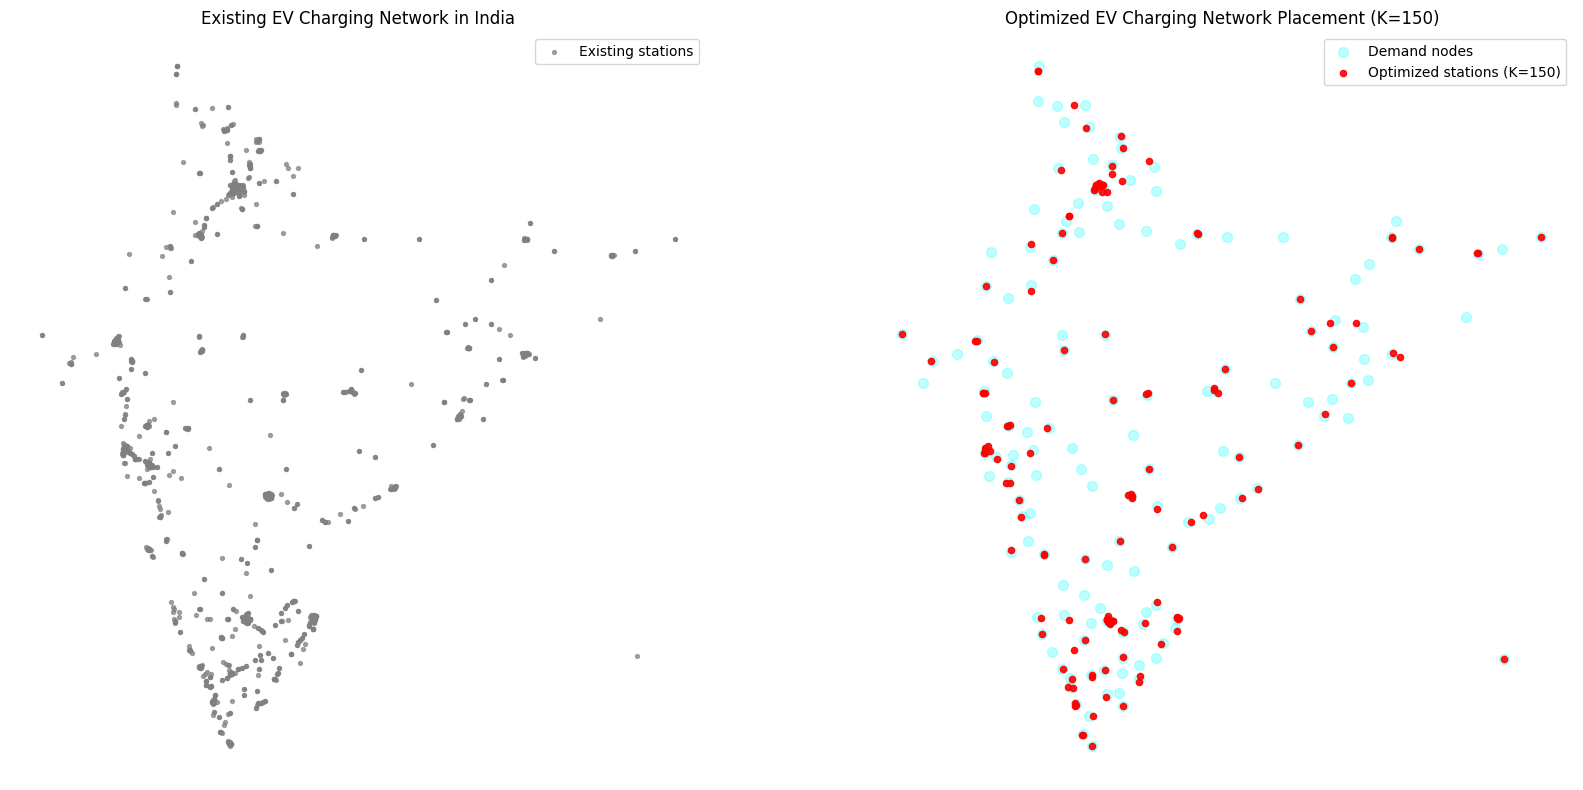

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Convert stations into geodataframes
gdf_all = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude),
    crs="EPSG:4326"
)

gdf_opt = gpd.GeoDataFrame(
    selected_stations_df,
    geometry=gpd.points_from_xy(selected_stations_df.longitude, selected_stations_df.latitude),
    crs="EPSG:4326"
)

# Demand nodes as geodataframe
gdf_demand = gpd.GeoDataFrame(
    demand_national_df,
    geometry=gpd.points_from_xy(demand_national_df.longitude, demand_national_df.latitude),
    crs="EPSG:4326"
)

# Load India boundary (if not available, fallback bounding box)
try:
    india_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    india_gdf = india_gdf[india_gdf.name == "India"]
except:
    india_gdf = None

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Panel 1: Existing network
if india_gdf is not None:
    india_gdf.plot(ax=ax[0], color="whitesmoke", edgecolor="gray")

gdf_all.plot(ax=ax[0], markersize=8, alpha=0.7, color="gray", label="Existing stations")
ax[0].set_title("Existing EV Charging Network in India")
ax[0].axis("off")
ax[0].legend()

# Panel 2: Optimized network + demand coverage radius
if india_gdf is not None:
    india_gdf.plot(ax=ax[1], color="whitesmoke", edgecolor="gray")

# Plot coverage for optimized stations
coverage_radius_km = R_SERVICE
#gdf_demand.buffer(coverage_radius_km / 110.0).plot(ax=ax[1], color="lightblue", alpha=0.18) # optional: slow
gdf_demand.plot(ax=ax[1], markersize=50, alpha=0.25, color="cyan", label="Demand nodes")

# Plot optimized
gdf_opt.plot(ax=ax[1], markersize=20, alpha=0.9, color="red", label="Optimized stations (K=150)")
ax[1].set_title("Optimized EV Charging Network Placement (K=150)")
ax[1].axis("off")
ax[1].legend()

plt.tight_layout()
plt.savefig("EV_Charging_Optimization_Comparison.png", dpi=300)
plt.show()
gdf_all.to_file("all_stations.geojson", driver="GeoJSON")
gdf_opt.to_file("optimized_stations.geojson", driver="GeoJSON")
gdf_demand.to_file("demand_nodes.geojson", driver="GeoJSON")


State-wise summary (first 10 rows):
   state_standard  all_stations  selected_stations
0         Andaman             1                  1
1  Andhra Pradesh            60                  6
2           Assam            10                  2
3           Bihar             7                  0
4      Chandigarh             2                  0
5    Chhattisgarh            18                  4
6           Delhi           178                  9
7             Goa             8                  2
8         Gujarat            79                  5
9         Haryana            62                  7

Gini (baseline, all stations):     0.584
Gini (optimized, selected K=150): 0.532


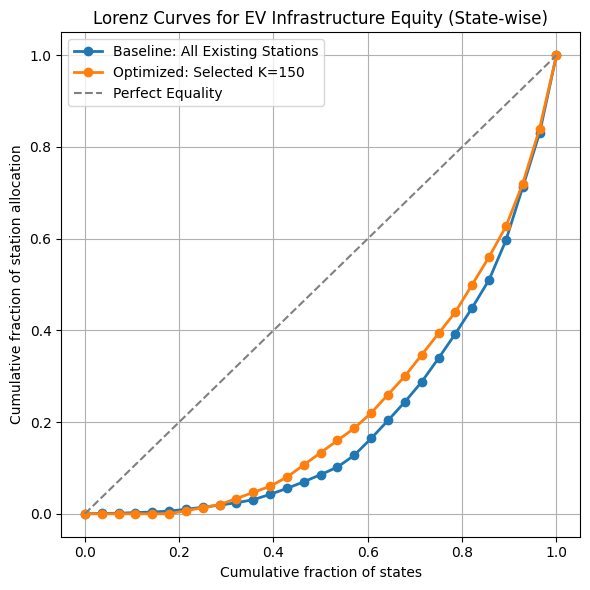

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 7. SPATIAL FAIRNESS: GINI + LORENZ CURVES
# ============================================================

# 7.1 Build state-wise baseline vs optimized summary (fresh, in case not defined)
stations_df_reg = stations_df.copy()
stations_df_reg["selected"] = best_x_nat.astype(int)

state_summary = (
    stations_df_reg
    .groupby("state_standard", as_index=False)
    .agg(
        all_stations=("station_id", "count"),
        selected_stations=("selected", "sum")
    )
)

print("State-wise summary (first 10 rows):")
print(state_summary.head(10))


# 7.2 Gini coefficient function
def gini_coefficient(values: np.ndarray) -> float:
    """
    Compute Gini coefficient of an array of non-negative values.
    0 = perfect equality, 1 = maximal inequality.
    """
    x = np.array(values, dtype=float)
    x = x[x >= 0]  # just in case
    if x.size == 0 or x.sum() == 0:
        return 0.0

    x_sorted = np.sort(x)
    n = len(x_sorted)
    cumulative = np.cumsum(x_sorted)
    gini = (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n
    return max(0.0, min(1.0, gini))


# 7.3 Lorenz curve plotting helper
def plot_lorenz_curve(values: np.ndarray,
                      label: str,
                      color: str = None):
    """
    Plot Lorenz curve for a given allocation vector.
    """
    x = np.array(values, dtype=float)
    x = x[x >= 0]
    if x.sum() == 0:
        raise ValueError("All values are zero; Lorenz curve not defined.")

    x_sorted = np.sort(x)
    cum_share = np.cumsum(x_sorted) / x_sorted.sum()
    cum_share = np.insert(cum_share, 0, 0.0)  # start at 0

    frac_states = np.linspace(0, 1, len(cum_share))

    plt.plot(frac_states, cum_share,
             marker="o",
             label=label,
             linewidth=2,
             color=color)


# 7.4 Compute Gini for baseline vs optimized
gini_all = gini_coefficient(state_summary["all_stations"].values)
gini_sel = gini_coefficient(state_summary["selected_stations"].values)

print(f"\nGini (baseline, all stations):     {gini_all:.3f}")
print(f"Gini (optimized, selected K=150): {gini_sel:.3f}")

# 7.5 Plot Lorenz curves
plt.figure(figsize=(6, 6))

plot_lorenz_curve(state_summary["all_stations"].values,
                  label="Baseline: All Existing Stations",
                  color="tab:blue")

plot_lorenz_curve(state_summary["selected_stations"].values,
                  label="Optimized: Selected K=150",
                  color="tab:orange")

# Line of perfect equality
plt.plot([0, 1], [0, 1],
         linestyle="--",
         color="gray",
         label="Perfect Equality")

plt.xlabel("Cumulative fraction of states")
plt.ylabel("Cumulative fraction of station allocation")
plt.title("Lorenz Curves for EV Infrastructure Equity (State-wise)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Lorenz_EV_Fairness.png", dpi=600, bbox_inches="tight")
plt.show()

Surrogate feature frame (head):
   station_id state_standard  selected  state_station_count  grid_index  \
0           0        Haryana         0                   62         0.0   
1           1        Haryana         0                   62         0.0   
2           2      Rajasthan         0                   67         0.0   
3           3  Uttar Pradesh         0                   87         0.0   
4           4  Uttar Pradesh         1                   87         0.0   

   avg_weighted_distance  min_distance  
0            1168.421289      5.094809  
1            1067.930813      5.184791  
2            1046.196532     16.007611  
3            1142.432238      0.916971  
4            1142.432238      0.916971  

Class balance: selected=150, not selected=1383

Random Forest surrogate performance (on training set):
              precision    recall  f1-score   support

           0      0.999     0.943     0.970      1383
           1      0.654     0.993     0.788       150

   

/tmp/ipython-input-3884959139.py:109: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


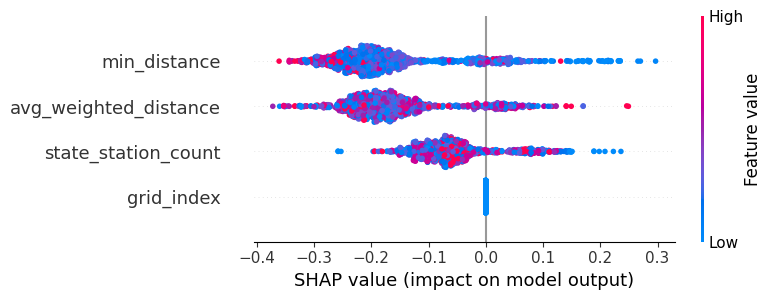


Example station for local explanation:
station_id                           4
state_standard           Uttar Pradesh
selected                             1
state_station_count                 87
grid_index                         0.0
avg_weighted_distance      1142.432238
min_distance                  0.916971
Name: 4, dtype: object
example_shap.shape (after squeeze): (4,)


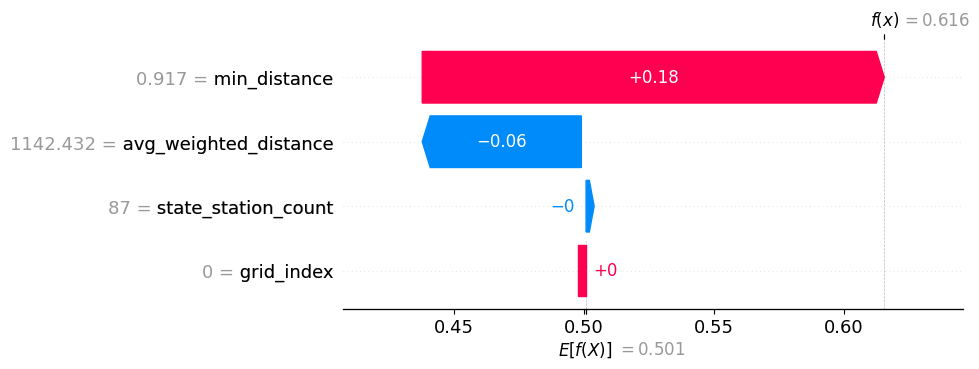

In [ ]:
# ============================================================
# 7B. EXPLAINABLE SURROGATE MODEL FOR STATION SELECTION
#      (Random Forest + SHAP)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 7B.1 Build feature dataframe
# -----------------------------

# Start from stations_df and attach optimization outcome
surrogate_df = stations_df.copy().reset_index(drop=True)
surrogate_df["selected"] = best_x_nat.astype(int)

n_stations = surrogate_df.shape[0]

# (1) State-level saturation: how many stations already exist in that state?
surrogate_df["state_station_count"] = (
    surrogate_df.groupby("state_standard")["station_id"]
    .transform("count")
)

# (2) Grid-stress index at that station’s region (from G_national and region_idx_national)
surrogate_df["grid_index"] = G_national[region_idx_national]

# (3) Average weighted distance to demand nodes
#     dist_national has shape (n_demand, n_stations)
avg_w_dist = np.average(dist_national, axis=0, weights=w_national)
surrogate_df["avg_weighted_distance"] = avg_w_dist

# (4) Minimum distance to any demand node (proxy for how “central” the station is)
min_dist = dist_national.min(axis=0)
surrogate_df["min_distance"] = min_dist

print("Surrogate feature frame (head):")
print(
    surrogate_df[
        [
            "station_id",
            "state_standard",
            "selected",
            "state_station_count",
            "grid_index",
            "avg_weighted_distance",
            "min_distance",
        ]
    ].head()
)

# -----------------------------
# 7B.2 Train Random Forest surrogate
# -----------------------------

feature_cols = [
    "state_station_count",
    "grid_index",
    "avg_weighted_distance",
    "min_distance",
]

X = surrogate_df[feature_cols].values
y = surrogate_df["selected"].values

print(f"\nClass balance: selected={y.sum()}, not selected={len(y) - y.sum()}")

rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
)
rf_model.fit(X, y)

y_pred = rf_model.predict(X)
print("\nRandom Forest surrogate performance (on training set):")
print(classification_report(y, y_pred, digits=3))

# -----------------------------
# 7B.3 Global explainability with SHAP
# -----------------------------

explainer = shap.TreeExplainer(rf_model)
raw_shap_values = explainer.shap_values(X)

# Handle different SHAP output formats:
#  - list [class0, class1, ...]
#  - array (n_samples, n_features)
#  - array (n_samples, n_features, n_outputs)
if isinstance(raw_shap_values, list):
    # binary classifier → index 1 = class "1" (selected)
    shap_for_selected = raw_shap_values[1]  # shape (n_samples, n_features)
elif isinstance(raw_shap_values, np.ndarray) and raw_shap_values.ndim == 3:
    # shape (n_samples, n_features, n_outputs)
    shap_for_selected = raw_shap_values[:, :, 1]  # take output dim 1
else:
    # already (n_samples, n_features)
    shap_for_selected = raw_shap_values

print("shap_for_selected.shape:", shap_for_selected.shape)

# Summary plot: which features drive selection decisions?
plt.figure(figsize=(6, 5))
shap.summary_plot(
    shap_for_selected,
    X,
    feature_names=feature_cols,
    show=False,          # we'll save, then show
)
plt.tight_layout()
plt.savefig("SHAP_summary_EV_surrogate.png", dpi=600, bbox_inches="tight")
plt.show()

# -----------------------------
# 7B.4 Example station-level explanation (single sample)
# -----------------------------

# Pick one GA-selected station index
selected_indices = np.where(best_x_nat == 1)[0]
if selected_indices.size == 0:
    raise ValueError("No stations are selected in best_x_nat; cannot do local SHAP example.")

example_idx = int(selected_indices[0])
example_row = surrogate_df.iloc[example_idx]

print("\nExample station for local explanation:")
print(example_row[["station_id", "state_standard", "selected"] + feature_cols])

# 1D SHAP values for this station (for the 'selected' class)
example_shap_raw = shap_for_selected[example_idx, :]  # may be 1D or 2D depending on SHAP

# If still 2D (n_features, n_outputs), reduce to one output (take column 0 or 1)
if example_shap_raw.ndim == 2:
    # assume second column corresponds to positive / selected outcome
    example_shap = example_shap_raw[:, 1]
else:
    example_shap = example_shap_raw

print("example_shap.shape (after squeeze):", example_shap.shape)

# 1D feature vector
example_features = surrogate_df.loc[example_idx, feature_cols]

# Decide base value for class 1
exp_val = explainer.expected_value
if isinstance(exp_val, (list, np.ndarray)):
    base_val = exp_val[1]
else:
    base_val = exp_val

# Waterfall plot (paper-friendly local explanation)
shap.waterfall_plot(
    shap.Explanation(
        values=example_shap,          # (n_features,)
        base_values=base_val,         # scalar
        data=example_features.values, # feature values
        feature_names=feature_cols,
    ),
    show=False                        # 🔹 important: don't auto-show/clear
)

fig = plt.gcf()                       # get current figure that SHAP just drew
fig.savefig("SHAP_waterfall_EV_example.png",
            dpi=600,
            bbox_inches="tight")
plt.show()



[Surrogate collection] GA run 1/10
Generation 20/300 -> best J(x) = 26465.41
Generation 40/300 -> best J(x) = 23263.15
Generation 60/300 -> best J(x) = 22642.86
Generation 80/300 -> best J(x) = 22642.86
Generation 100/300 -> best J(x) = 22642.86
Generation 120/300 -> best J(x) = 21779.41
Generation 140/300 -> best J(x) = 21779.41
Generation 160/300 -> best J(x) = 21779.41
Generation 180/300 -> best J(x) = 21779.41
Generation 200/300 -> best J(x) = 21779.41
Generation 220/300 -> best J(x) = 21779.41
Generation 240/300 -> best J(x) = 21779.41
Generation 260/300 -> best J(x) = 21779.41
Generation 280/300 -> best J(x) = 21779.41
Generation 300/300 -> best J(x) = 21760.56

[Surrogate collection] GA run 2/10
Generation 20/300 -> best J(x) = 27615.71
Generation 40/300 -> best J(x) = 23766.20
Generation 60/300 -> best J(x) = 23665.09
Generation 80/300 -> best J(x) = 22571.30
Generation 100/300 -> best J(x) = 22571.30
Generation 120/300 -> best J(x) = 22571.30
Generation 140/300 -> best J(x) =

/tmp/ipython-input-1714579291.py:188: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


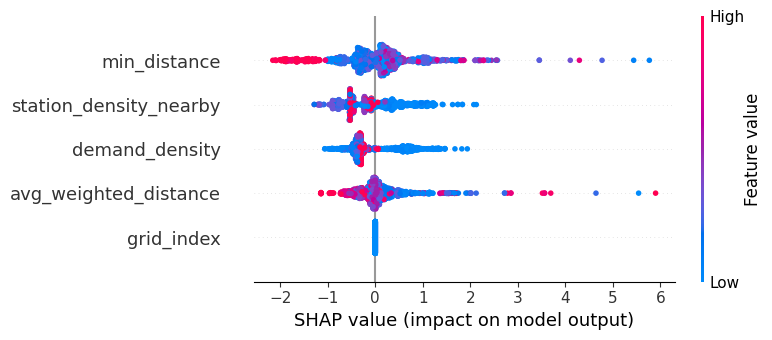

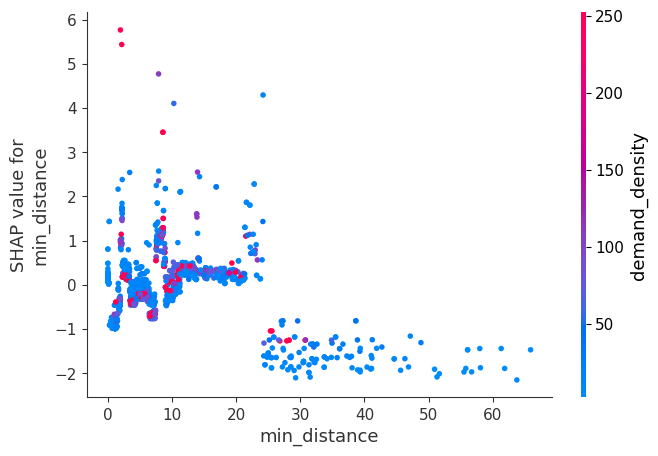

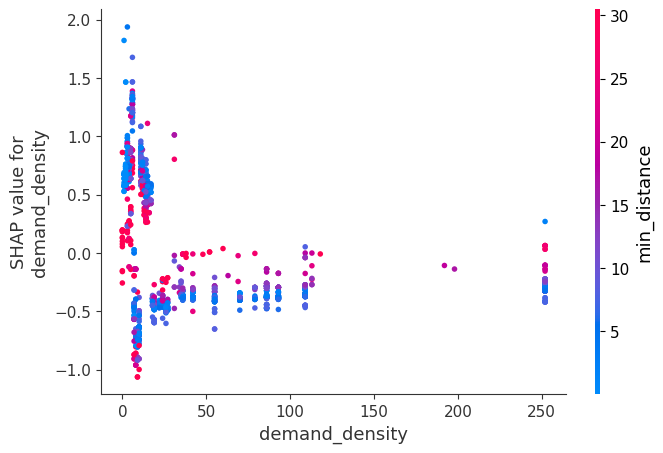

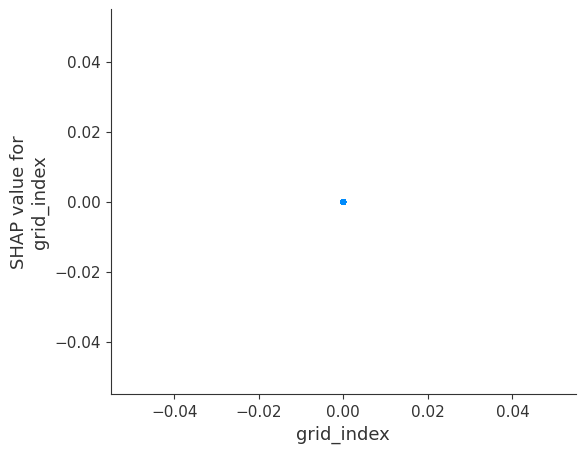


Example station (y=1) for local SHAP explanation:
station_id                         29
state_standard                Haryana
y_label                             1
grid_index                        0.0
demand_density                  252.0
min_distance                 1.957321
avg_weighted_distance     1066.231864
station_density_nearby          250.0
Name: 29, dtype: object


In [ ]:
# ============================================================
# 7C. ADVANCED SURROGATE + SHAP (MATCHING METHODOLOGY H)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import shap

# -----------------------------
# 7C.1 Collect a diverse set of GA solutions {x^(k)}
# -----------------------------

N_SURR_RUNS = 10  # you can increase to 15–20 if runtime allows

solutions = []
objectives = []

for run in range(N_SURR_RUNS):
    print(f"\n[Surrogate collection] GA run {run+1}/{N_SURR_RUNS}")
    np.random.seed(2025 + run)

    result = run_ga(
        dist_matrix=dist_national,
        weights=w_national,
        region_idx=region_idx_national,
        G=G_national,
        K=K_STATIONS,
        alpha=ALPHA,
        beta=BETA,
        R=R_SERVICE,
        theta=THETA_COVERAGE,
        pop_size=POP_SIZE,
        n_generations=N_GENERATIONS,
    )

    x_best = result["best_x"]
    J_best = result["best_f"]

    solutions.append(x_best)
    objectives.append(J_best)

solutions = np.array(solutions)   # shape: (N_SURR_RUNS, n_stations)
objectives = np.array(objectives)

print("\nCollected GA solutions for surrogate:")
print("Solutions shape:", solutions.shape)
print("Objective values:", objectives)

# -----------------------------
# 7C.2 Define “good” solutions (on / near Pareto-like front)
# -----------------------------

# Simple, defensible choice: take top q% by objective
q = 0.3  # top 30% runs as "good"
threshold = np.quantile(objectives, q)

good_mask = objectives <= threshold
good_solutions = solutions[good_mask]

print(f"\nGood solutions (top {int(q*100)}%): {good_solutions.shape[0]} of {N_SURR_RUNS}")
print("Good-solution objective range:", objectives[good_mask].min(), "to", objectives[good_mask].max())

# -----------------------------
# 7C.3 Compute station-level selection frequency and labels y_l
# -----------------------------

# selection_frequency[l] = fraction of good solutions in which station l was selected
selection_frequency = good_solutions.mean(axis=0)   # shape: (n_stations,)

# Define label y_l as in Eq. (17): 1 if "often selected" in good solutions
freq_threshold = 0.4  # you can tune 0.3–0.5
y_labels = (selection_frequency >= freq_threshold).astype(int)

print("\nSelection frequency stats:")
print("Min:", selection_frequency.min(), "Max:", selection_frequency.max())
print("Stations labeled 1 (frequent in good sols):", y_labels.sum())
print("Stations labeled 0:", len(y_labels) - y_labels.sum())

# -----------------------------
# 7C.4 Construct feature vectors z_l for each station
#      (grid stress, demand density, proximity, station density)
# -----------------------------

sur_df = stations_df.copy().reset_index(drop=True)
n_stations = sur_df.shape[0]

# (1) Regional grid-stress index G_j
sur_df["grid_index"] = G_national[region_idx_national]

# (2) Demand density = total demand weight within radius R_DEMAND
R_DEMAND = 50.0  # km, you can adjust
# dist_national: (n_demand, n_stations)
within_R = (dist_national <= R_DEMAND).astype(float)
local_demand_density = (within_R * w_national.reshape(-1, 1)).sum(axis=0)
sur_df["demand_density"] = local_demand_density

# (3) Proximity to demand clusters: min distance + weighted mean
min_dist = dist_national.min(axis=0)
avg_weighted_dist = np.average(dist_national, axis=0, weights=w_national)
sur_df["min_distance"] = min_dist
sur_df["avg_weighted_distance"] = avg_weighted_dist

# (4) Existing station density in neighbourhood
#     count of stations within R_NEIGH km of each station
R_NEIGH = 50.0  # km
coords = sur_df[["latitude", "longitude"]].values
station_density = np.zeros(n_stations)

# Use Haversine again (vectorized pairwise may be heavy; simple loop ok for ~1500)
import math

def haversine_km(lat1, lon1, lat2, lon2):
    R_earth = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R_earth * c

for i in range(n_stations):
    lat_i, lon_i = coords[i]
    count = 0
    for j in range(n_stations):
        if i == j:
            continue
        lat_j, lon_j = coords[j]
        d = haversine_km(lat_i, lon_i, lat_j, lon_j)
        if d <= R_NEIGH:
            count += 1
    station_density[i] = count

sur_df["station_density_nearby"] = station_density

# Attach labels
sur_df["y_label"] = y_labels

feature_cols = [
    "grid_index",
    "demand_density",
    "min_distance",
    "avg_weighted_distance",
    "station_density_nearby",
]

print("\nSurrogate dataset head:")
print(sur_df[["station_id", "state_standard", "y_label"] + feature_cols].head())

# -----------------------------
# 7C.5 Train Gradient-Boosted Trees surrogate \hat{f}(z_l)
# -----------------------------

X_surr = sur_df[feature_cols].values
y_surr = sur_df["y_label"].values

print("\nLabel balance for surrogate:")
print("y=1 (frequent in good sols):", y_surr.sum())
print("y=0:", len(y_surr) - y_surr.sum())

gb_model = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)
gb_model.fit(X_surr, y_surr)

y_pred_surr = gb_model.predict(X_surr)
print("\nGradient-Boosted surrogate performance (on full station set):")
print(classification_report(y_surr, y_pred_surr, digits=3))

# -----------------------------
# 7C.6 SHAP-based explanation: global and local
# -----------------------------

explainer_gb = shap.TreeExplainer(gb_model)
shap_values = explainer_gb.shap_values(X_surr)

# For binary classifier, shap_values is usually array of shape (n_samples, n_features)
# (for some versions, it's a list; handle both cases)
if isinstance(shap_values, list):
    shap_surr = shap_values[1]  # class 1 (y=1)
else:
    shap_surr = shap_values

# Global summary: which features drive selection probability y_l=1?
shap.summary_plot(
    shap_surr,
    X_surr,
    feature_names=feature_cols,
    show=True
)

# Example dependence plot: non-linear threshold behaviour
for feat in ["min_distance", "demand_density", "grid_index"]:
    shap.dependence_plot(
        feat,
        shap_surr,
        X_surr,
        feature_names=feature_cols,
        show=True
    )

# Optional: local explanation for one "frequently selected" station
example_idx = int(np.where(y_surr == 1)[0][0])
example_row = sur_df.iloc[example_idx]

print("\nExample station (y=1) for local SHAP explanation:")
print(example_row[["station_id", "state_standard", "y_label"] + feature_cols])

example_features = X_surr[example_idx]
example_shap = shap_surr[example_idx]

shap.force_plot(
    explainer_gb.expected_value,
    example_shap,
    example_features,
    feature_names=feature_cols
)


In [ ]:
# ============================================================
# 7C. ADVANCED SURROGATE + SHAP (MATCHING METHODOLOGY H)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import shap

# NEW: for saving high-res PNGs
import matplotlib.pyplot as plt
import os

# directory where all SHAP images will be saved
FIG_DIR = "shap_plots"
os.makedirs(FIG_DIR, exist_ok=True)

# -----------------------------
# 7C.1 Collect a diverse set of GA solutions {x^(k)}
# -----------------------------

N_SURR_RUNS = 10  # you can increase to 15–20 if runtime allows

solutions = []
objectives = []

for run in range(N_SURR_RUNS):
    print(f"\n[Surrogate collection] GA run {run+1}/{N_SURR_RUNS}")
    np.random.seed(2025 + run)

    result = run_ga(
        dist_matrix=dist_national,
        weights=w_national,
        region_idx=region_idx_national,
        G=G_national,
        K=K_STATIONS,
        alpha=ALPHA,
        beta=BETA,
        R=R_SERVICE,
        theta=THETA_COVERAGE,
        pop_size=POP_SIZE,
        n_generations=N_GENERATIONS,
    )

    x_best = result["best_x"]
    J_best = result["best_f"]

    solutions.append(x_best)
    objectives.append(J_best)

solutions = np.array(solutions)   # shape: (N_SURR_RUNS, n_stations)
objectives = np.array(objectives)

print("\nCollected GA solutions for surrogate:")
print("Solutions shape:", solutions.shape)
print("Objective values:", objectives)

# -----------------------------
# 7C.2 Define “good” solutions (on / near Pareto-like front)
# -----------------------------

# Simple, defensible choice: take top q% by objective
q = 0.3  # top 30% runs as "good"
threshold = np.quantile(objectives, q)

good_mask = objectives <= threshold
good_solutions = solutions[good_mask]

print(f"\nGood solutions (top {int(q*100)}%): {good_solutions.shape[0]} of {N_SURR_RUNS}")
print("Good-solution objective range:", objectives[good_mask].min(), "to", objectives[good_mask].max())

# -----------------------------
# 7C.3 Compute station-level selection frequency and labels y_l
# -----------------------------

# selection_frequency[l] = fraction of good solutions in which station l was selected
selection_frequency = good_solutions.mean(axis=0)   # shape: (n_stations,)

# Define label y_l as in Eq. (17): 1 if "often selected" in good solutions
freq_threshold = 0.4  # you can tune 0.3–0.5
y_labels = (selection_frequency >= freq_threshold).astype(int)

print("\nSelection frequency stats:")
print("Min:", selection_frequency.min(), "Max:", selection_frequency.max())
print("Stations labeled 1 (frequent in good sols):", y_labels.sum())
print("Stations labeled 0:", len(y_labels) - y_labels.sum())

# -----------------------------
# 7C.4 Construct feature vectors z_l for each station
#      (grid stress, demand density, proximity, station density)
# -----------------------------

sur_df = stations_df.copy().reset_index(drop=True)
n_stations = sur_df.shape[0]

# (1) Regional grid-stress index G_j
sur_df["grid_index"] = G_national[region_idx_national]

# (2) Demand density = total demand weight within radius R_DEMAND
R_DEMAND = 50.0  # km, you can adjust
# dist_national: (n_demand, n_stations)
within_R = (dist_national <= R_DEMAND).astype(float)
local_demand_density = (within_R * w_national.reshape(-1, 1)).sum(axis=0)
sur_df["demand_density"] = local_demand_density

# (3) Proximity to demand clusters: min distance + weighted mean
min_dist = dist_national.min(axis=0)
avg_weighted_dist = np.average(dist_national, axis=0, weights=w_national)
sur_df["min_distance"] = min_dist
sur_df["avg_weighted_distance"] = avg_weighted_dist

# (4) Existing station density in neighbourhood
#     count of stations within R_NEIGH km of each station
R_NEIGH = 50.0  # km
coords = sur_df[["latitude", "longitude"]].values
station_density = np.zeros(n_stations)

# Use Haversine again (vectorized pairwise may be heavy; simple loop ok for ~1500)
import math

def haversine_km(lat1, lon1, lat2, lon2):
    R_earth = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lat2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R_earth * c

for i in range(n_stations):
    lat_i, lon_i = coords[i]
    count = 0
    for j in range(n_stations):
        if i == j:
            continue
        lat_j, lon_j = coords[j]
        d = haversine_km(lat_i, lon_i, lat_j, lon_j)
        if d <= R_NEIGH:
            count += 1
    station_density[i] = count

sur_df["station_density_nearby"] = station_density

# Attach labels
sur_df["y_label"] = y_labels

feature_cols = [
    "grid_index",
    "demand_density",
    "min_distance",
    "avg_weighted_distance",
    "station_density_nearby",
]

print("\nSurrogate dataset head:")
print(sur_df[["station_id", "state_standard", "y_label"] + feature_cols].head())

# -----------------------------
# 7C.5 Train Gradient-Boosted Trees surrogate \hat{f}(z_l)
# -----------------------------

X_surr = sur_df[feature_cols].values
y_surr = sur_df["y_label"].values

print("\nLabel balance for surrogate:")
print("y=1 (frequent in good sols):", y_surr.sum())
print("y=0:", len(y_surr) - y_surr.sum())

gb_model = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)
gb_model.fit(X_surr, y_surr)

y_pred_surr = gb_model.predict(X_surr)
print("\nGradient-Boosted surrogate performance (on full station set):")
print(classification_report(y_surr, y_pred_surr, digits=3))

# ----



[Surrogate collection] GA run 1/10
Generation 20/300 -> best J(x) = 26465.41
Generation 40/300 -> best J(x) = 23263.15
Generation 60/300 -> best J(x) = 22642.86
Generation 80/300 -> best J(x) = 22642.86
Generation 100/300 -> best J(x) = 22642.86
Generation 120/300 -> best J(x) = 21779.41
Generation 140/300 -> best J(x) = 21779.41
Generation 160/300 -> best J(x) = 21779.41
Generation 180/300 -> best J(x) = 21779.41
Generation 200/300 -> best J(x) = 21779.41
Generation 220/300 -> best J(x) = 21779.41
Generation 240/300 -> best J(x) = 21779.41
Generation 260/300 -> best J(x) = 21779.41
Generation 280/300 -> best J(x) = 21779.41
Generation 300/300 -> best J(x) = 21760.56

[Surrogate collection] GA run 2/10
Generation 20/300 -> best J(x) = 27615.71
Generation 40/300 -> best J(x) = 23766.20
Generation 60/300 -> best J(x) = 23665.09
Generation 80/300 -> best J(x) = 22571.30
Generation 100/300 -> best J(x) = 22571.30
Generation 120/300 -> best J(x) = 22571.30
Generation 140/300 -> best J(x) =


[Surrogate collection] GA run 1/10
Generation 20/300 -> best J(x) = 26465.41
Generation 40/300 -> best J(x) = 23263.15
Generation 60/300 -> best J(x) = 22642.86
Generation 80/300 -> best J(x) = 22642.86
Generation 100/300 -> best J(x) = 22642.86
Generation 120/300 -> best J(x) = 21779.41
Generation 140/300 -> best J(x) = 21779.41
Generation 160/300 -> best J(x) = 21779.41
Generation 180/300 -> best J(x) = 21779.41
Generation 200/300 -> best J(x) = 21779.41
Generation 220/300 -> best J(x) = 21779.41
Generation 240/300 -> best J(x) = 21779.41
Generation 260/300 -> best J(x) = 21779.41
Generation 280/300 -> best J(x) = 21779.41
Generation 300/300 -> best J(x) = 21760.56

[Surrogate collection] GA run 2/10
Generation 20/300 -> best J(x) = 27615.71
Generation 40/300 -> best J(x) = 23766.20
Generation 60/300 -> best J(x) = 23665.09
Generation 80/300 -> best J(x) = 22571.30
Generation 100/300 -> best J(x) = 22571.30
Generation 120/300 -> best J(x) = 22571.30
Generation 140/300 -> best J(x) =

/tmp/ipython-input-4156464246.py:199: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


<Figure size 640x480 with 0 Axes>

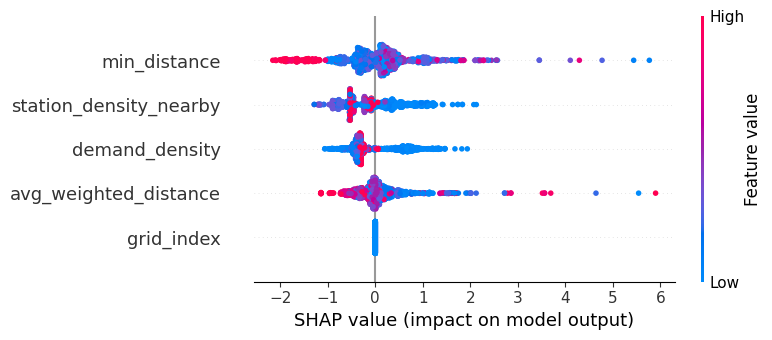

<Figure size 600x300 with 0 Axes>

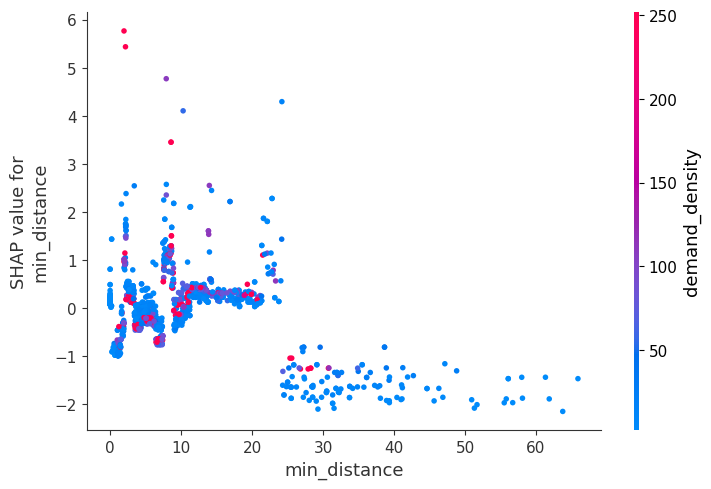

<Figure size 600x300 with 0 Axes>

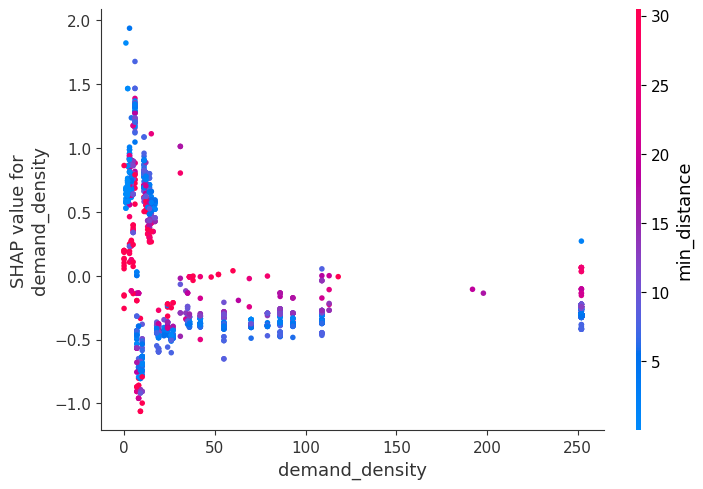

<Figure size 600x300 with 0 Axes>

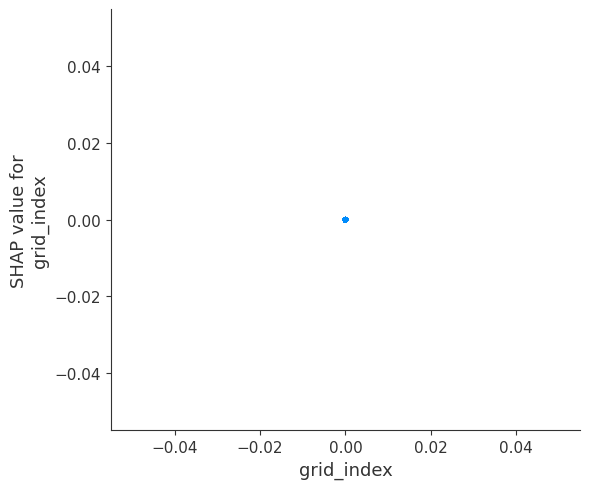


Example station (y=1) for local SHAP explanation:
station_id                         29
state_standard                Haryana
y_label                             1
grid_index                        0.0
demand_density                  252.0
min_distance                 1.957321
avg_weighted_distance     1066.231864
station_density_nearby          250.0
Name: 29, dtype: object


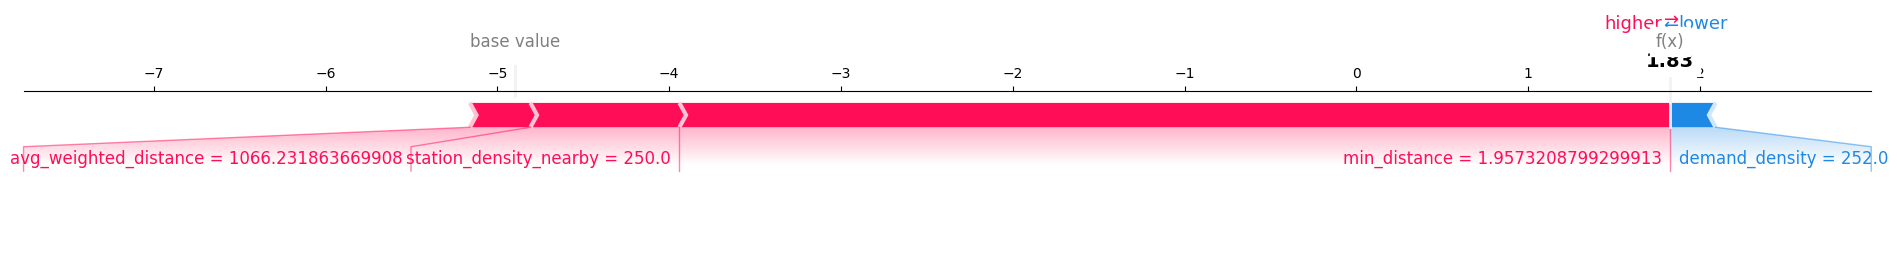

In [ ]:
# ============================================================
# 7C. ADVANCED SURROGATE + SHAP (MATCHING METHODOLOGY H)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import shap

# NEW: for saving high-res PNGs without changing display behaviour
import matplotlib.pyplot as plt
import os

# directory where all SHAP images will be saved
FIG_DIR = "shap_plots"
os.makedirs(FIG_DIR, exist_ok=True)

# -----------------------------
# 7C.1 Collect a diverse set of GA solutions {x^(k)}
# -----------------------------

N_SURR_RUNS = 10  # you can increase to 15–20 if runtime allows

solutions = []
objectives = []

for run in range(N_SURR_RUNS):
    print(f"\n[Surrogate collection] GA run {run+1}/{N_SURR_RUNS}")
    np.random.seed(2025 + run)

    result = run_ga(
        dist_matrix=dist_national,
        weights=w_national,
        region_idx=region_idx_national,
        G=G_national,
        K=K_STATIONS,
        alpha=ALPHA,
        beta=BETA,
        R=R_SERVICE,
        theta=THETA_COVERAGE,
        pop_size=POP_SIZE,
        n_generations=N_GENERATIONS,
    )

    x_best = result["best_x"]
    J_best = result["best_f"]

    solutions.append(x_best)
    objectives.append(J_best)

solutions = np.array(solutions)   # shape: (N_SURR_RUNS, n_stations)
objectives = np.array(objectives)

print("\nCollected GA solutions for surrogate:")
print("Solutions shape:", solutions.shape)
print("Objective values:", objectives)

# -----------------------------
# 7C.2 Define “good” solutions (on / near Pareto-like front)
# -----------------------------

# Simple, defensible choice: take top q% by objective
q = 0.3  # top 30% runs as "good"
threshold = np.quantile(objectives, q)

good_mask = objectives <= threshold
good_solutions = solutions[good_mask]

print(f"\nGood solutions (top {int(q*100)}%): {good_solutions.shape[0]} of {N_SURR_RUNS}")
print("Good-solution objective range:", objectives[good_mask].min(), "to", objectives[good_mask].max())

# -----------------------------
# 7C.3 Compute station-level selection frequency and labels y_l
# -----------------------------

# selection_frequency[l] = fraction of good solutions in which station l was selected
selection_frequency = good_solutions.mean(axis=0)   # shape: (n_stations,)

# Define label y_l as in Eq. (17): 1 if "often selected" in good solutions
freq_threshold = 0.4  # you can tune 0.3–0.5
y_labels = (selection_frequency >= freq_threshold).astype(int)

print("\nSelection frequency stats:")
print("Min:", selection_frequency.min(), "Max:", selection_frequency.max())
print("Stations labeled 1 (frequent in good sols):", y_labels.sum())
print("Stations labeled 0:", len(y_labels) - y_labels.sum())

# -----------------------------
# 7C.4 Construct feature vectors z_l for each station
#      (grid stress, demand density, proximity, station density)
# -----------------------------

sur_df = stations_df.copy().reset_index(drop=True)
n_stations = sur_df.shape[0]

# (1) Regional grid-stress index G_j
sur_df["grid_index"] = G_national[region_idx_national]

# (2) Demand density = total demand weight within radius R_DEMAND
R_DEMAND = 50.0  # km, you can adjust
# dist_national: (n_demand, n_stations)
within_R = (dist_national <= R_DEMAND).astype(float)
local_demand_density = (within_R * w_national.reshape(-1, 1)).sum(axis=0)
sur_df["demand_density"] = local_demand_density

# (3) Proximity to demand clusters: min distance + weighted mean
min_dist = dist_national.min(axis=0)
avg_weighted_dist = np.average(dist_national, axis=0, weights=w_national)
sur_df["min_distance"] = min_dist
sur_df["avg_weighted_distance"] = avg_weighted_dist

# (4) Existing station density in neighbourhood
#     count of stations within R_NEIGH km of each station
R_NEIGH = 50.0  # km
coords = sur_df[["latitude", "longitude"]].values
station_density = np.zeros(n_stations)

# Use Haversine again (vectorized pairwise may be heavy; simple loop ok for ~1500)
import math

def haversine_km(lat1, lon1, lat2, lon2):
    R_earth = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R_earth * c

for i in range(n_stations):
    lat_i, lon_i = coords[i]
    count = 0
    for j in range(n_stations):
        if i == j:
            continue
        lat_j, lon_j = coords[j]
        d = haversine_km(lat_i, lon_i, lat_j, lon_j)
        if d <= R_NEIGH:
            count += 1
    station_density[i] = count

sur_df["station_density_nearby"] = station_density

# Attach labels
sur_df["y_label"] = y_labels

feature_cols = [
    "grid_index",
    "demand_density",
    "min_distance",
    "avg_weighted_distance",
    "station_density_nearby",
]

print("\nSurrogate dataset head:")
print(sur_df[["station_id", "state_standard", "y_label"] + feature_cols].head())

# -----------------------------
# 7C.5 Train Gradient-Boosted Trees surrogate \hat{f}(z_l)
# -----------------------------

X_surr = sur_df[feature_cols].values
y_surr = sur_df["y_label"].values

print("\nLabel balance for surrogate:")
print("y=1 (frequent in good sols):", y_surr.sum())
print("y=0:", len(y_surr) - y_surr.sum())

gb_model = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)
gb_model.fit(X_surr, y_surr)

y_pred_surr = gb_model.predict(X_surr)
print("\nGradient-Boosted surrogate performance (on full station set):")
print(classification_report(y_surr, y_pred_surr, digits=3))

# -----------------------------
# 7C.6 SHAP-based explanation: global and local
# -----------------------------

explainer_gb = shap.TreeExplainer(gb_model)
shap_values = explainer_gb.shap_values(X_surr)

# For binary classifier, shap_values is usually array of shape (n_samples, n_features)
# (for some versions, it's a list; handle both cases)
if isinstance(shap_values, list):
    shap_surr = shap_values[1]  # class 1 (y=1)
else:
    shap_surr = shap_values

# ===== Global summary: which features drive selection probability y_l=1? =====
import matplotlib.pyplot as plt  # in case not imported above

plt.figure(figsize=(6, 3))
shap.summary_plot(
    shap_surr,
    X_surr,
    feature_names=feature_cols,
    show=False      # don't auto-show; we will save
)
plt.tight_layout()
plt.savefig("7C_SHAP_summary_global.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close()

# ===== Example dependence plots: non-linear threshold behaviour =====
for feat in ["min_distance", "demand_density", "grid_index"]:
    plt.figure(figsize=(6, 3))
    shap.dependence_plot(
        feat,
        shap_surr,
        X_surr,
        feature_names=feature_cols,
        show=False
    )
    plt.tight_layout()
    plt.savefig(f"7C_SHAP_dependence_{feat}.png", dpi=600, bbox_inches="tight")
    plt.show()
    plt.close()

# ===== Optional: local explanation for one "frequently selected" station =====
example_idx = int(np.where(y_surr == 1)[0][0])
example_row = sur_df.iloc[example_idx]

print("\nExample station (y=1) for local SHAP explanation:")
print(example_row[["station_id", "state_standard", "y_label"] + feature_cols])

example_features = X_surr[example_idx]
example_shap = shap_surr[example_idx]

shap.force_plot(
    explainer_gb.expected_value,
    example_shap,
    example_features,
    feature_names=feature_cols,
    matplotlib=True,   # force Matplotlib backend
    show=False
)
plt.tight_layout()
plt.savefig("7C_SHAP_local_force.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close()


In [ ]:
hub = surrogate_df[surrogate_df["station_id"] == 29]
print(hub)


           name    state      city  \
29  JMD Gardens  Haryana  Gurugram   

                                              address  latitude  longitude  \
29  Unnamed Road, Sector 33, Gurugram, Haryana 122018   28.4336    77.0349   

    type state_standard  \
29  12.0        Haryana   

    no._of_electric_vehicle_(ev)_charging_stations_installed  \
29                                             1287.0          

    yearwise_rows_count  pcs_state_max  station_id  selected  \
29                    4         1287.0          29         1   

    state_station_count  grid_index  avg_weighted_distance  min_distance  
29                   62         0.0            1066.231864      1.957321  


solutions shape: (10, 1533)

Candidate solution pool stats:
  D(x):   min=20267.10, max=22630.65
  Ψ(x):   min=0.00, max=0.00
  cov(x): min=0.676, max=0.750

=== α–β sensitivity over GA solution pool ===
   alpha  beta       best_J        best_D  best_Psi  best_cov  \
0   0.00  1.00     0.000000  21754.628513       0.0  0.720809   
1   0.05  0.95  1013.355078  20267.101556       0.0  0.730594   
2   0.10  0.90  2026.710156  20267.101556       0.0  0.730594   
3   0.15  0.85  3040.065233  20267.101556       0.0  0.730594   
4   0.20  0.80  4053.420311  20267.101556       0.0  0.730594   

   best_solution_index  
0                    0  
1                    2  
2                    2  
3                    2  
4                    2  


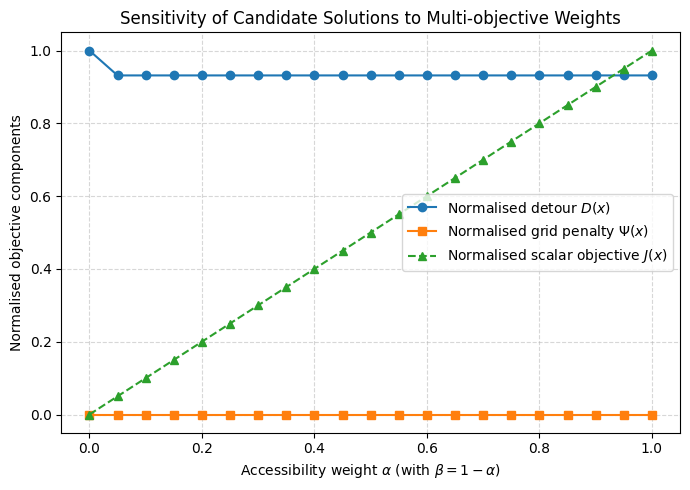


=== Best weight (within scanned α grid, over solution pool) ===
alpha                      0.000000
beta                       1.000000
best_J                     0.000000
best_D                 21754.628513
best_Psi                   0.000000
best_cov                   0.720809
best_solution_index        0.000000
D_norm                     1.000000
Psi_norm                   0.000000
J_norm                     0.000000
Name: 0, dtype: float64


In [ ]:
# ============================================================
# 8. SENSITIVITY ANALYSIS OVER MULTI-OBJECTIVE WEIGHTS (α, β)
#    USING EXISTING GA SOLUTION POOL (NO NEW GA RUNS)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 'solutions' should be from 7C:
# solutions.shape = (N_SOLUTIONS, n_stations)
print("solutions shape:", solutions.shape)

# 1) Pre-compute D(x), Ψ(x) and coverage for each candidate solution
D_list = []
Psi_list = []
cov_list = []

for k, x in enumerate(solutions):
    D_val, cov_val = compute_detour_and_coverage(
        x, dist_national, w_national, R_SERVICE, THETA_COVERAGE
    )
    Psi_val = compute_grid_penalty(x, region_idx_national, G_national)
    D_list.append(D_val)
    Psi_list.append(Psi_val)
    cov_list.append(cov_val)

D_arr   = np.array(D_list)   # shape (N_SOLUTIONS,)
Psi_arr = np.array(Psi_list)
cov_arr = np.array(cov_list)

print("\nCandidate solution pool stats:")
print("  D(x):   min={:.2f}, max={:.2f}".format(D_arr.min(), D_arr.max()))
print("  Ψ(x):   min={:.2f}, max={:.2f}".format(Psi_arr.min(), Psi_arr.max()))
print("  cov(x): min={:.3f}, max={:.3f}".format(cov_arr.min(), cov_arr.max()))

# 2) Sweep α in [0,1], with β = 1 - α, and pick the best solution from pool
alpha_grid = np.linspace(0.0, 1.0, 21)   # 0.0, 0.05, ..., 1.0

records = []
for alpha_w in alpha_grid:
    beta_w = 1.0 - alpha_w

    # Scalarised objective for all candidate solutions
    J_all = alpha_w * D_arr + beta_w * Psi_arr
    best_idx = int(np.argmin(J_all))

    records.append({
        "alpha": alpha_w,
        "beta": beta_w,
        "best_J": J_all[best_idx],
        "best_D": D_arr[best_idx],
        "best_Psi": Psi_arr[best_idx],
        "best_cov": cov_arr[best_idx],
        "best_solution_index": best_idx,
    })

sweep_df = pd.DataFrame(records)
print("\n=== α–β sensitivity over GA solution pool ===")
print(sweep_df.head())

# 3) Normalise D, Ψ, and J for plotting
D_max   = sweep_df["best_D"].max()
Psi_max = sweep_df["best_Psi"].max() if sweep_df["best_Psi"].max() > 0 else 1.0
J_max   = sweep_df["best_J"].max()

sweep_df["D_norm"]   = sweep_df["best_D"]   / D_max
sweep_df["Psi_norm"] = sweep_df["best_Psi"] / Psi_max
sweep_df["J_norm"]   = sweep_df["best_J"]   / J_max

# 4) Plot: normalised D(x), Ψ(x), and J(x) vs α
plt.figure(figsize=(7, 5))

plt.plot(
    sweep_df["alpha"], sweep_df["D_norm"],
    marker="o", label=r"Normalised detour $D(x)$"
)
plt.plot(
    sweep_df["alpha"], sweep_df["Psi_norm"],
    marker="s", label=r"Normalised grid penalty $\Psi(x)$"
)
plt.plot(
    sweep_df["alpha"], sweep_df["J_norm"],
    marker="^", linestyle="--", label=r"Normalised scalar objective $J(x)$"
)

plt.xlabel(r"Accessibility weight $\alpha$ (with $\beta = 1 - \alpha$)")
plt.ylabel("Normalised objective components")
plt.title("Sensitivity of Candidate Solutions to Multi-objective Weights")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig("weight_sensitivity_alpha_beta_pool_600dpi.png",
            dpi=600, bbox_inches="tight")
plt.show()

# 5) Report α where J is minimal within this pool
best_row = sweep_df.loc[sweep_df["best_J"].idxmin()]
print("\n=== Best weight (within scanned α grid, over solution pool) ===")
print(best_row)
